# Module 6 Project: Covid Data Analysis with Regression

`Module Coordinator: Pranav Tadimeti`

In this project, we will use the concepts of regression and regularization we have learnt to predict early Covid-19 cases. We shall use linear regression, polynomial regression and ridge regression to obtain a reasonably good estimate of the future cases. Try experimenting with hyperparameters to obtain better results.

## Data Analysis

### 1. **Load the data** into a pandas dataframe.

In [1]:
# Imports
import pandas as pd
import numpy  as np
import scipy.integrate

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import copy
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.linear_model  import LinearRegression, BayesianRidge
from   sklearn.tree          import DecisionTreeRegressor
from   sklearn.preprocessing import PolynomialFeatures

In [2]:
path = "https://raw.githubusercontent.com/PranavTadimeti/Regression_Project/main/covid_19_data.csv"
df_orig = pd.read_csv(path)
print(df_orig.head())

   SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


### 2. Create a new dataframe which counts the cumulative total number of cases, the cumulative total number of deaths, and also  cumulative total number of recoveries for each date.

In [3]:
df = copy.deepcopy(df_orig)
df.drop('Last Update',inplace=True,axis=1)
date_lst  = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp
    

In [4]:
date_dict

{'01/22/2020':     SNo ObservationDate  Province/State  Country/Region  Confirmed  Deaths  \
 0     1      01/22/2020           Anhui  Mainland China        1.0     0.0   
 1     2      01/22/2020         Beijing  Mainland China       14.0     0.0   
 2     3      01/22/2020       Chongqing  Mainland China        6.0     0.0   
 3     4      01/22/2020          Fujian  Mainland China        1.0     0.0   
 4     5      01/22/2020           Gansu  Mainland China        0.0     0.0   
 5     6      01/22/2020       Guangdong  Mainland China       26.0     0.0   
 6     7      01/22/2020         Guangxi  Mainland China        2.0     0.0   
 7     8      01/22/2020         Guizhou  Mainland China        1.0     0.0   
 8     9      01/22/2020          Hainan  Mainland China        4.0     0.0   
 9    10      01/22/2020           Hebei  Mainland China        1.0     0.0   
 10   11      01/22/2020    Heilongjiang  Mainland China        0.0     0.0   
 11   12      01/22/2020           Hen

In [5]:
df1 = pd.DataFrame(df).set_index("SNo")
df1

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
SNo,,,,,,
1,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...
10667,03/31/2020,Wyoming,US,109.0,0.0,0.0
10668,03/31/2020,Xinjiang,Mainland China,76.0,3.0,73.0
10669,03/31/2020,Yukon,Canada,5.0,0.0,0.0


In [6]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp
    

In [7]:
date_tot_tup_dict

{'01/22/2020': (555.0, 17.0, 28.0),
 '01/23/2020': (653.0, 18.0, 30.0),
 '01/24/2020': (941.0, 26.0, 36.0),
 '01/25/2020': (1438.0, 42.0, 39.0),
 '01/26/2020': (2118.0, 56.0, 52.0),
 '01/27/2020': (2927.0, 82.0, 61.0),
 '01/28/2020': (5578.0, 131.0, 107.0),
 '01/29/2020': (6165.0, 133.0, 126.0),
 '01/30/2020': (8235.0, 171.0, 143.0),
 '01/31/2020': (9925.0, 213.0, 222.0),
 '02/01/2020': (12038.0, 259.0, 284.0),
 '02/02/2020': (16787.0, 362.0, 472.0),
 '02/03/2020': (19881.0, 426.0, 623.0),
 '02/04/2020': (23892.0, 492.0, 852.0),
 '02/05/2020': (27636.0, 564.0, 1124.0),
 '02/06/2020': (30818.0, 634.0, 1487.0),
 '02/07/2020': (34392.0, 719.0, 2011.0),
 '02/08/2020': (37121.0, 806.0, 2616.0),
 '02/09/2020': (40151.0, 906.0, 3244.0),
 '02/10/2020': (42763.0, 1013.0, 3946.0),
 '02/11/2020': (44803.0, 1113.0, 4683.0),
 '02/12/2020': (45222.0, 1118.0, 5150.0),
 '02/13/2020': (60370.0, 1371.0, 6295.0),
 '02/14/2020': (66887.0, 1523.0, 8058.0),
 '02/15/2020': (69032.0, 1666.0, 9395.0),
 '02/16/

In [8]:
df_date_tots_ut = pd.DataFrame(date_tot_tup_dict)
df_date_tots = df_date_tots_ut.transpose()
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
print(df_date_tots)

            Confirmed   Deaths  Recovered
01/22/2020      555.0     17.0       28.0
01/23/2020      653.0     18.0       30.0
01/24/2020      941.0     26.0       36.0
01/25/2020     1438.0     42.0       39.0
01/26/2020     2118.0     56.0       52.0
...               ...      ...        ...
03/27/2020   593291.0  27198.0   130915.0
03/28/2020   660706.0  30652.0   139415.0
03/29/2020   720117.0  33925.0   149082.0
03/30/2020   782365.0  37582.0   164566.0
03/31/2020   857487.0  42107.0   178034.0

[70 rows x 3 columns]


In [9]:
df_date_tots_ut

,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,01/30/2020,01/31/2020,...,03/22/2020,03/23/2020,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/28/2020,03/29/2020,03/30/2020,03/31/2020
0,555.0,653.0,941.0,1438.0,2118.0,2927.0,5578.0,6165.0,8235.0,9925.0,...,337020.0,378287.0,417966.0,467594.0,529591.0,593291.0,660706.0,720117.0,782365.0,857487.0
1,17.0,18.0,26.0,42.0,56.0,82.0,131.0,133.0,171.0,213.0,...,14623.0,16497.0,18615.0,21181.0,23970.0,27198.0,30652.0,33925.0,37582.0,42107.0
2,28.0,30.0,36.0,39.0,52.0,61.0,107.0,126.0,143.0,222.0,...,97243.0,100958.0,107705.0,113770.0,122150.0,130915.0,139415.0,149082.0,164566.0,178034.0


### 3. **Plot** the total number of cases per day over time and summarize findings

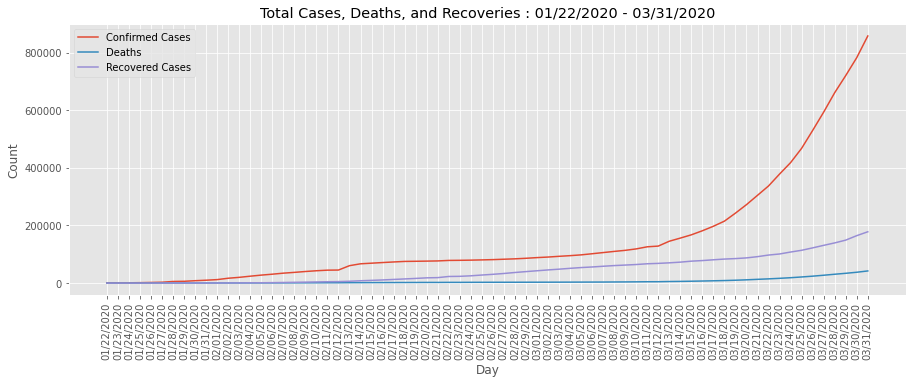

In [10]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases")
plt.plot(df_date_tots['Deaths'], label    = "Deaths")
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);


All of the three curves seem to be exponential (start of logistic curve). The confirmed cases was obviously higher than the deaths and recovered cases. The rate of the the recovered cases seems to be higher than that of the death curve.

### 4. Create a new column in the dataframe called **“closed cases”**

In [11]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']

### 5. Create a new column in the dataframe called “active cases”

In [12]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']

In [13]:
df_date_tots

,Confirmed,Deaths,Recovered,Closed Cases,Active Cases
01/22/2020,555.0,17.0,28.0,45.0,510.0
01/23/2020,653.0,18.0,30.0,48.0,605.0
01/24/2020,941.0,26.0,36.0,62.0,879.0
01/25/2020,1438.0,42.0,39.0,81.0,1357.0
01/26/2020,2118.0,56.0,52.0,108.0,2010.0
...,...,...,...,...,...
03/27/2020,593291.0,27198.0,130915.0,158113.0,435178.0
03/28/2020,660706.0,30652.0,139415.0,170067.0,490639.0
03/29/2020,720117.0,33925.0,149082.0,183007.0,537110.0
03/30/2020,782365.0,37582.0,164566.0,202148.0,580217.0


### 6. Create one **plot** showing the trend of number of active cases and closed cases 

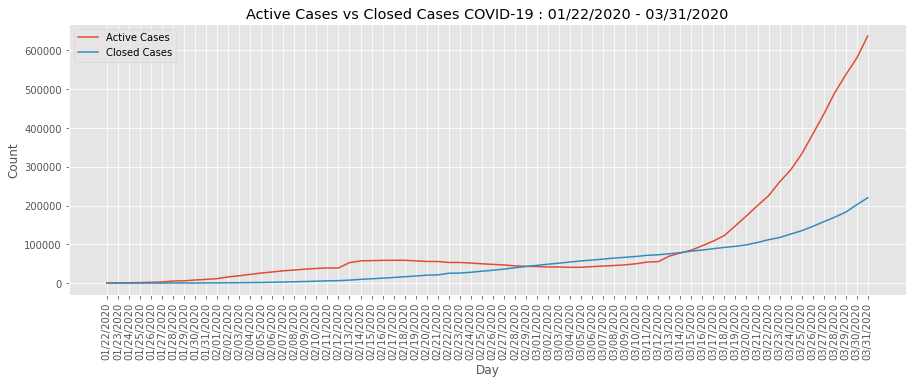

In [14]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Active Cases'], label = "Active Cases")
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases")

plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date);

The number of active cases is higher than the number of closed cases as of yet.

### 7. Growth Factor

In [15]:
growth_len_lst = len(date_lst) - 1
confirmed_lst = df_date_tots["Confirmed"]
death_lst = df_date_tots["Deaths"]
recovered_lst = df_date_tots["Recovered"]
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] 
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i] 
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i] 
    recovGF_lst.append(recoveredGF);
  

Text(0.5, 1.0, 'Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : 01/22/2020 - 03/31/2020')

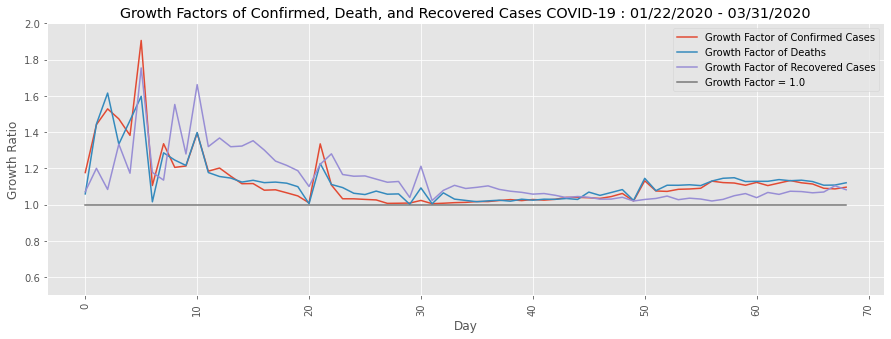

In [16]:
plt.figure(figsize = [15,5])
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases")
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths")
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases")
x = []
for i in range((growth_len_lst)):
    x.append(1)
plt.plot(x, label = "Growth Factor = 1.0")

#plt.grid()
plt.legend()
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +start_date +" - " +fin_date)

# **Part 2 - Prediction Using Linear Regression**

#### To make our data to be compatible with *sklearn* format, create a new column called “Days since” which tracks the number of days since the initial date.

In [17]:
days_since_lst = []
for i in range(len(date_lst)):
    days_since_lst.append(i)
df_date_tots["Days Since:"] = days_since_lst
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]]
df_date_tots

,Days Since:,Confirmed,Deaths,Recovered,Active Cases,Closed Cases
01/22/2020,0,555.0,17.0,28.0,510.0,45.0
01/23/2020,1,653.0,18.0,30.0,605.0,48.0
01/24/2020,2,941.0,26.0,36.0,879.0,62.0
01/25/2020,3,1438.0,42.0,39.0,1357.0,81.0
01/26/2020,4,2118.0,56.0,52.0,2010.0,108.0
...,...,...,...,...,...,...
03/27/2020,65,593291.0,27198.0,130915.0,435178.0,158113.0
03/28/2020,66,660706.0,30652.0,139415.0,490639.0,170067.0
03/29/2020,67,720117.0,33925.0,149082.0,537110.0,183007.0
03/30/2020,68,782365.0,37582.0,164566.0,580217.0,202148.0


### 8. Take the earliest 85% of the dates as **train** and the rest as **test**

In [18]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
y = np.array(df_date_tots["Confirmed"])


In [19]:
X

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

### 9. We can try different regression and regularizations we have seen before

#### 9.1 Linear Regression

In [21]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

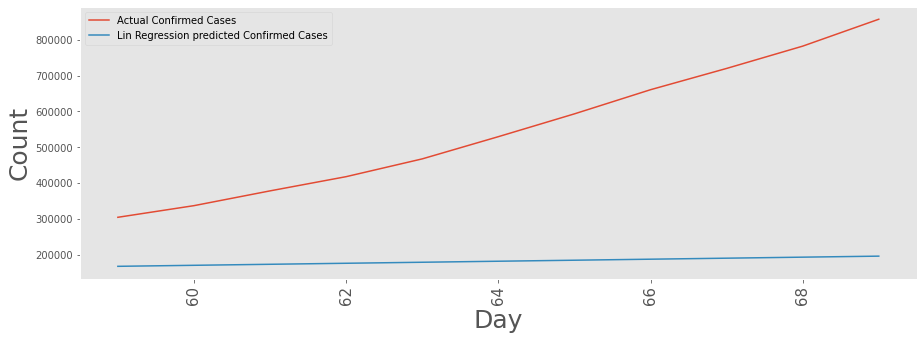

MAE: 368049.30417332525
MSE: 164288029427.18597


In [22]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, y_test))
print('MSE:', mean_squared_error  (test_lin_pred, y_test))

#### Polynomial Regression

In [23]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [24]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)


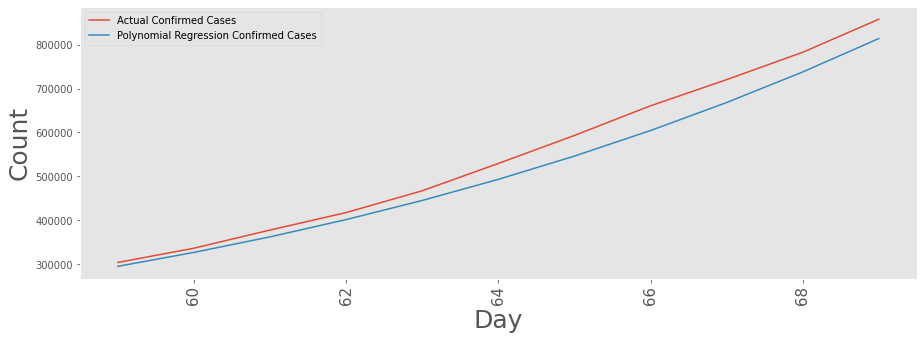

MAE: 31989.752678661967
MSE: 1314905592.3565953


In [25]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_pred,
         label = "Polynomial Regression Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

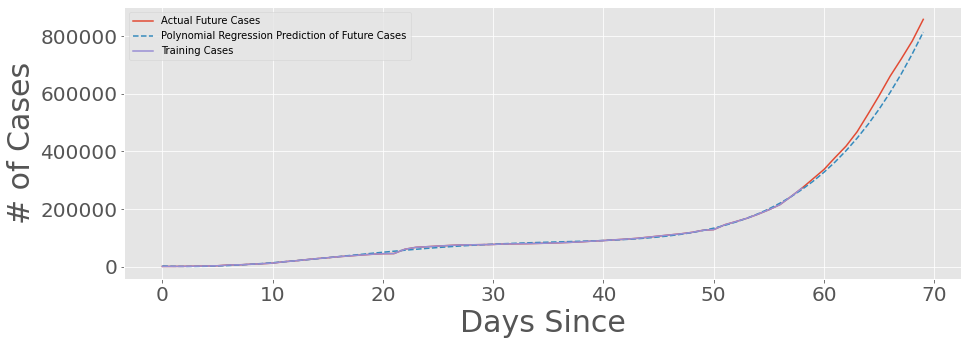

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.2 Ridge Regression

In [27]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 1e-05, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1e-07}


In [28]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

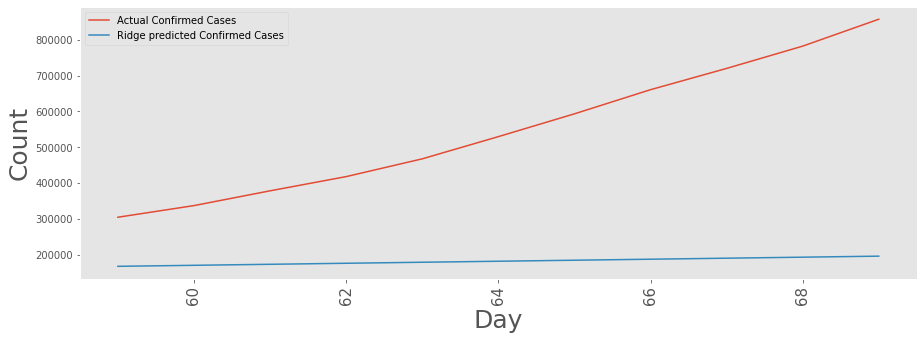

MAE: 368251.96606548695
MSE: 164440629513.48813


In [29]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, y_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, y_test))

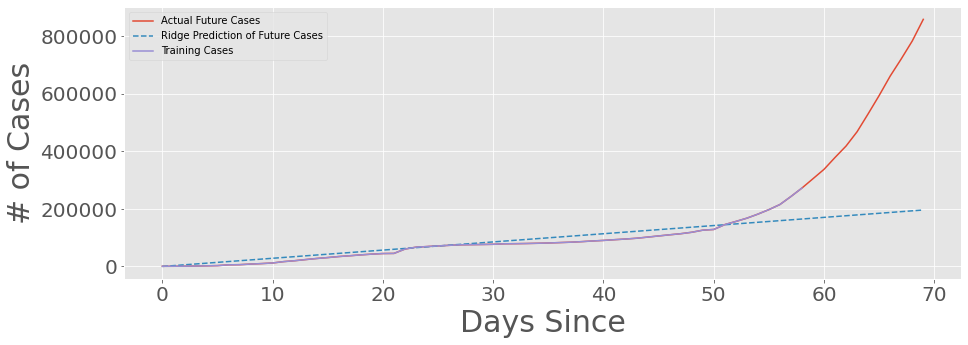

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

#### Polynomial Ridge Regression

In [31]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [32]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1e-07}


In [33]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

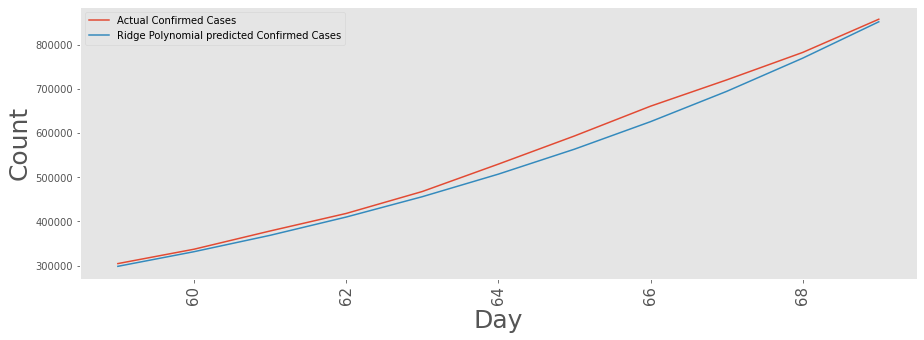

MAE: 15796.10443292518
MSE: 352565817.8330264


In [34]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_bayesian_pred,
         label = "Ridge Polynomial predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

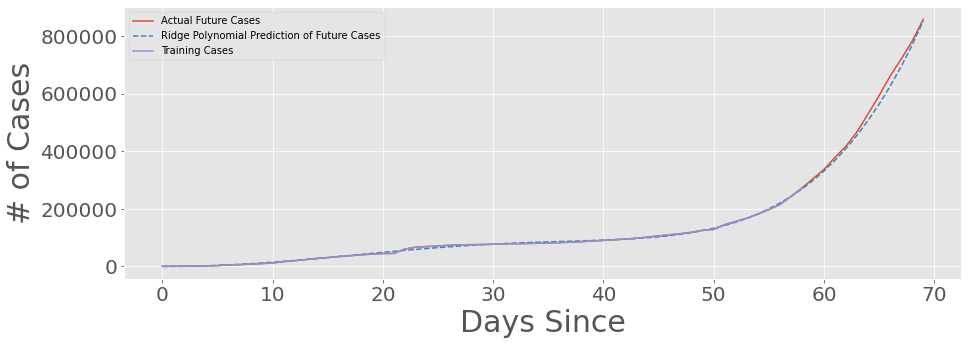

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [36]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 31989.752678661967
	MSE: 1314905592.3565953

Ridge Polynomial Regression 
	MAE: 15796.10443292518
	MSE: 352565817.8330264


From Mean Absolute Error and Mean Squared Error values, Ridge Polynomial Regression Model seems to be the best model.

#Part-3
##Further exploring data

In [37]:
#imports
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df_1 = copy.deepcopy(df_orig)
df1 = pd.DataFrame(df_1).set_index("SNo")
df1

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10667,03/31/2020,Wyoming,US,2020-03-31 23:49:27,109.0,0.0,0.0
10668,03/31/2020,Xinjiang,Mainland China,2020-03-31 23:49:27,76.0,3.0,73.0
10669,03/31/2020,Yukon,Canada,2020-03-31 23:49:27,5.0,0.0,0.0


In [39]:
country_list  = df1["Country/Region"].unique()
country_dict = {}

for i in range(len(country_list)):
    country_dict[country_list[i]] = df1.loc[df1["Country/Region"] == country_list[i],"Confirmed"].sum()
    

country_dict.pop(' Azerbaijan')
country_dict.pop("('St. Martin',)")
country_dict

{'Afghanistan': 1225.0,
 'Albania': 2232.0,
 'Algeria': 4828.0,
 'Andorra': 2787.0,
 'Angola': 48.0,
 'Antigua and Barbuda': 61.0,
 'Argentina': 6494.0,
 'Armenia': 4099.0,
 'Aruba': 19.0,
 'Australia': 36147.0,
 'Austria': 84819.0,
 'Azerbaijan': 1915.0,
 'Bahamas': 86.0,
 'Bahamas, The': 10.0,
 'Bahrain': 7926.0,
 'Bangladesh': 546.0,
 'Barbados': 255.0,
 'Belarus': 1467.0,
 'Belgium': 89035.0,
 'Belize': 18.0,
 'Benin': 68.0,
 'Bhutan': 46.0,
 'Bolivia': 682.0,
 'Bosnia and Herzegovina': 2822.0,
 'Botswana': 7.0,
 'Brazil': 37132.0,
 'Brunei': 1688.0,
 'Bulgaria': 3576.0,
 'Burkina Faso': 1901.0,
 'Burma': 55.0,
 'Burundi': 2.0,
 'Cabo Verde': 49.0,
 'Cambodia': 1259.0,
 'Cameroon': 1067.0,
 'Canada': 52258.0,
 'Cape Verde': 1.0,
 'Cayman Islands': 3.0,
 'Central African Republic': 41.0,
 'Chad': 35.0,
 'Channel Islands': 1.0,
 'Chile': 17663.0,
 'Colombia': 6132.0,
 'Congo (Brazzaville)': 97.0,
 'Congo (Kinshasa)': 642.0,
 'Costa Rica': 2987.0,
 'Croatia': 6422.0,
 'Cuba': 1020.0,


In [40]:
C_df = pd.DataFrame(country_dict, index=[0])
c_Df = C_df.transpose()
c_Df.columns = ["Confirmed"]
c_Df['Country'] = c_Df.index
c_Df['index'] = [i for i in range(len(c_Df))]
c_Df.sort_values(by = ["Confirmed"], ascending = False,inplace = True)
c_Df.set_index('index', inplace = True)
c_Df

,Confirmed,Country
index,,
0,4176244.0,Mainland China
26,1211089.0,Italy
4,1087452.0,US
30,742532.0,Spain
22,588757.0,Germany
...,...,...
171,1.0,The Gambia
165,1.0,Republic of the Congo
61,1.0,North Ireland


In [41]:
c_Df.describe()


,Confirmed
count,2.130000e+02
mean,4.978905e+04
std,3.153015e+05
min,1.000000e+00
25%,5.500000e+01
50%,8.410000e+02
75%,6.494000e+03
max,4.176244e+06


In [42]:
cdf = c_Df.loc[ c_Df["Confirmed"] > c_Df["Confirmed"].mean()]
cdf

,Confirmed,Country
index,,
0,4176244.0,Mainland China
26,1211089.0,Italy
4,1087452.0,US
30,742532.0,Spain
22,588757.0,Germany
34,527564.0,Iran
16,410165.0,France
7,257018.0,South Korea
27,165726.0,UK


In [43]:
cdf_low = c_Df.loc[ c_Df["Confirmed"] <= c_Df["Confirmed"].mean()]
cdf_low

,Confirmed,Country
index,,
72,46919.0,Portugal
29,43918.0,Sweden
14,37132.0,Brazil
12,36147.0,Australia
35,34856.0,Israel
...,...,...
171,1.0,The Gambia
165,1.0,Republic of the Congo
61,1.0,North Ireland


In [44]:
cdf_low.describe()

,Confirmed
count,197.000000
mean,4290.081218
std,8327.763154
min,1.000000
25%,52.000000
50%,587.000000
75%,4099.000000
max,46919.000000


In [45]:
#percentage of cases in top 15 countries compared to the ROW
p = cdf["Confirmed"].sum()/c_Df["Confirmed"].sum()
p = p*100
p

92.03073473927749

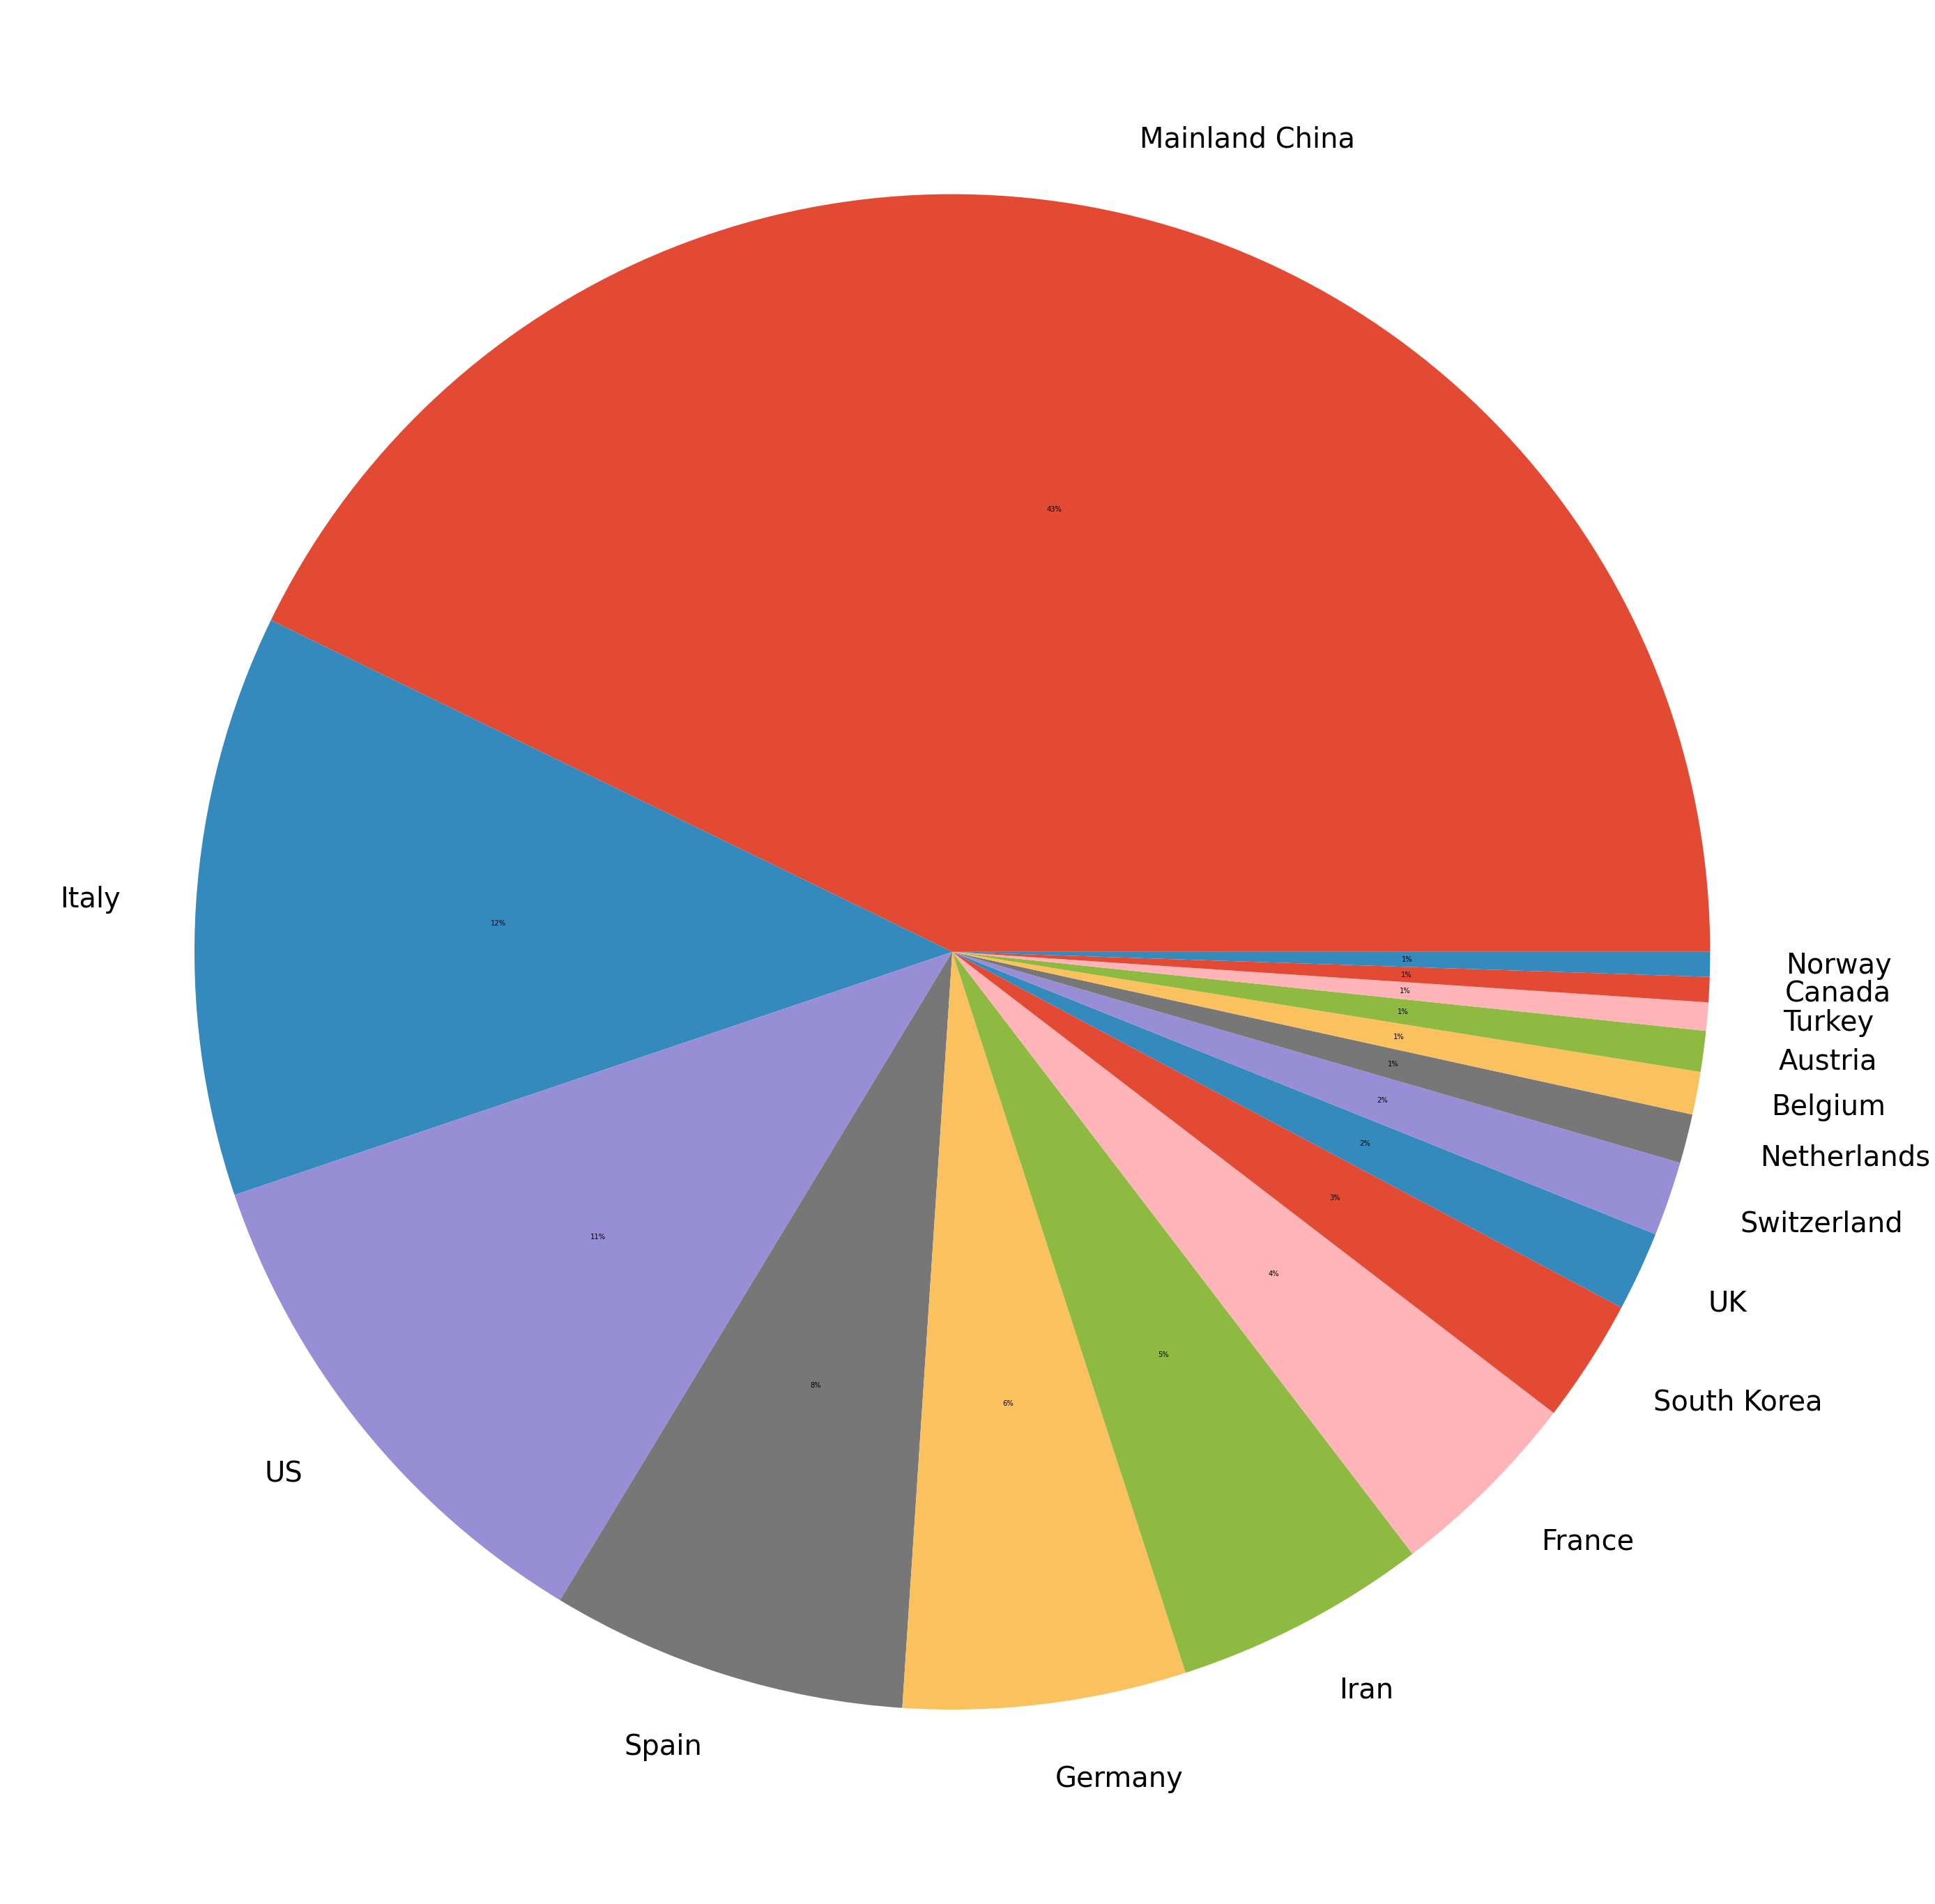

In [46]:
plt.figure(figsize=(100, 50))
plt.xticks(rotation = 45)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40)
plt.pie( cdf["Confirmed"], labels = cdf["Country"],autopct='%.0f%%')
plt.show()

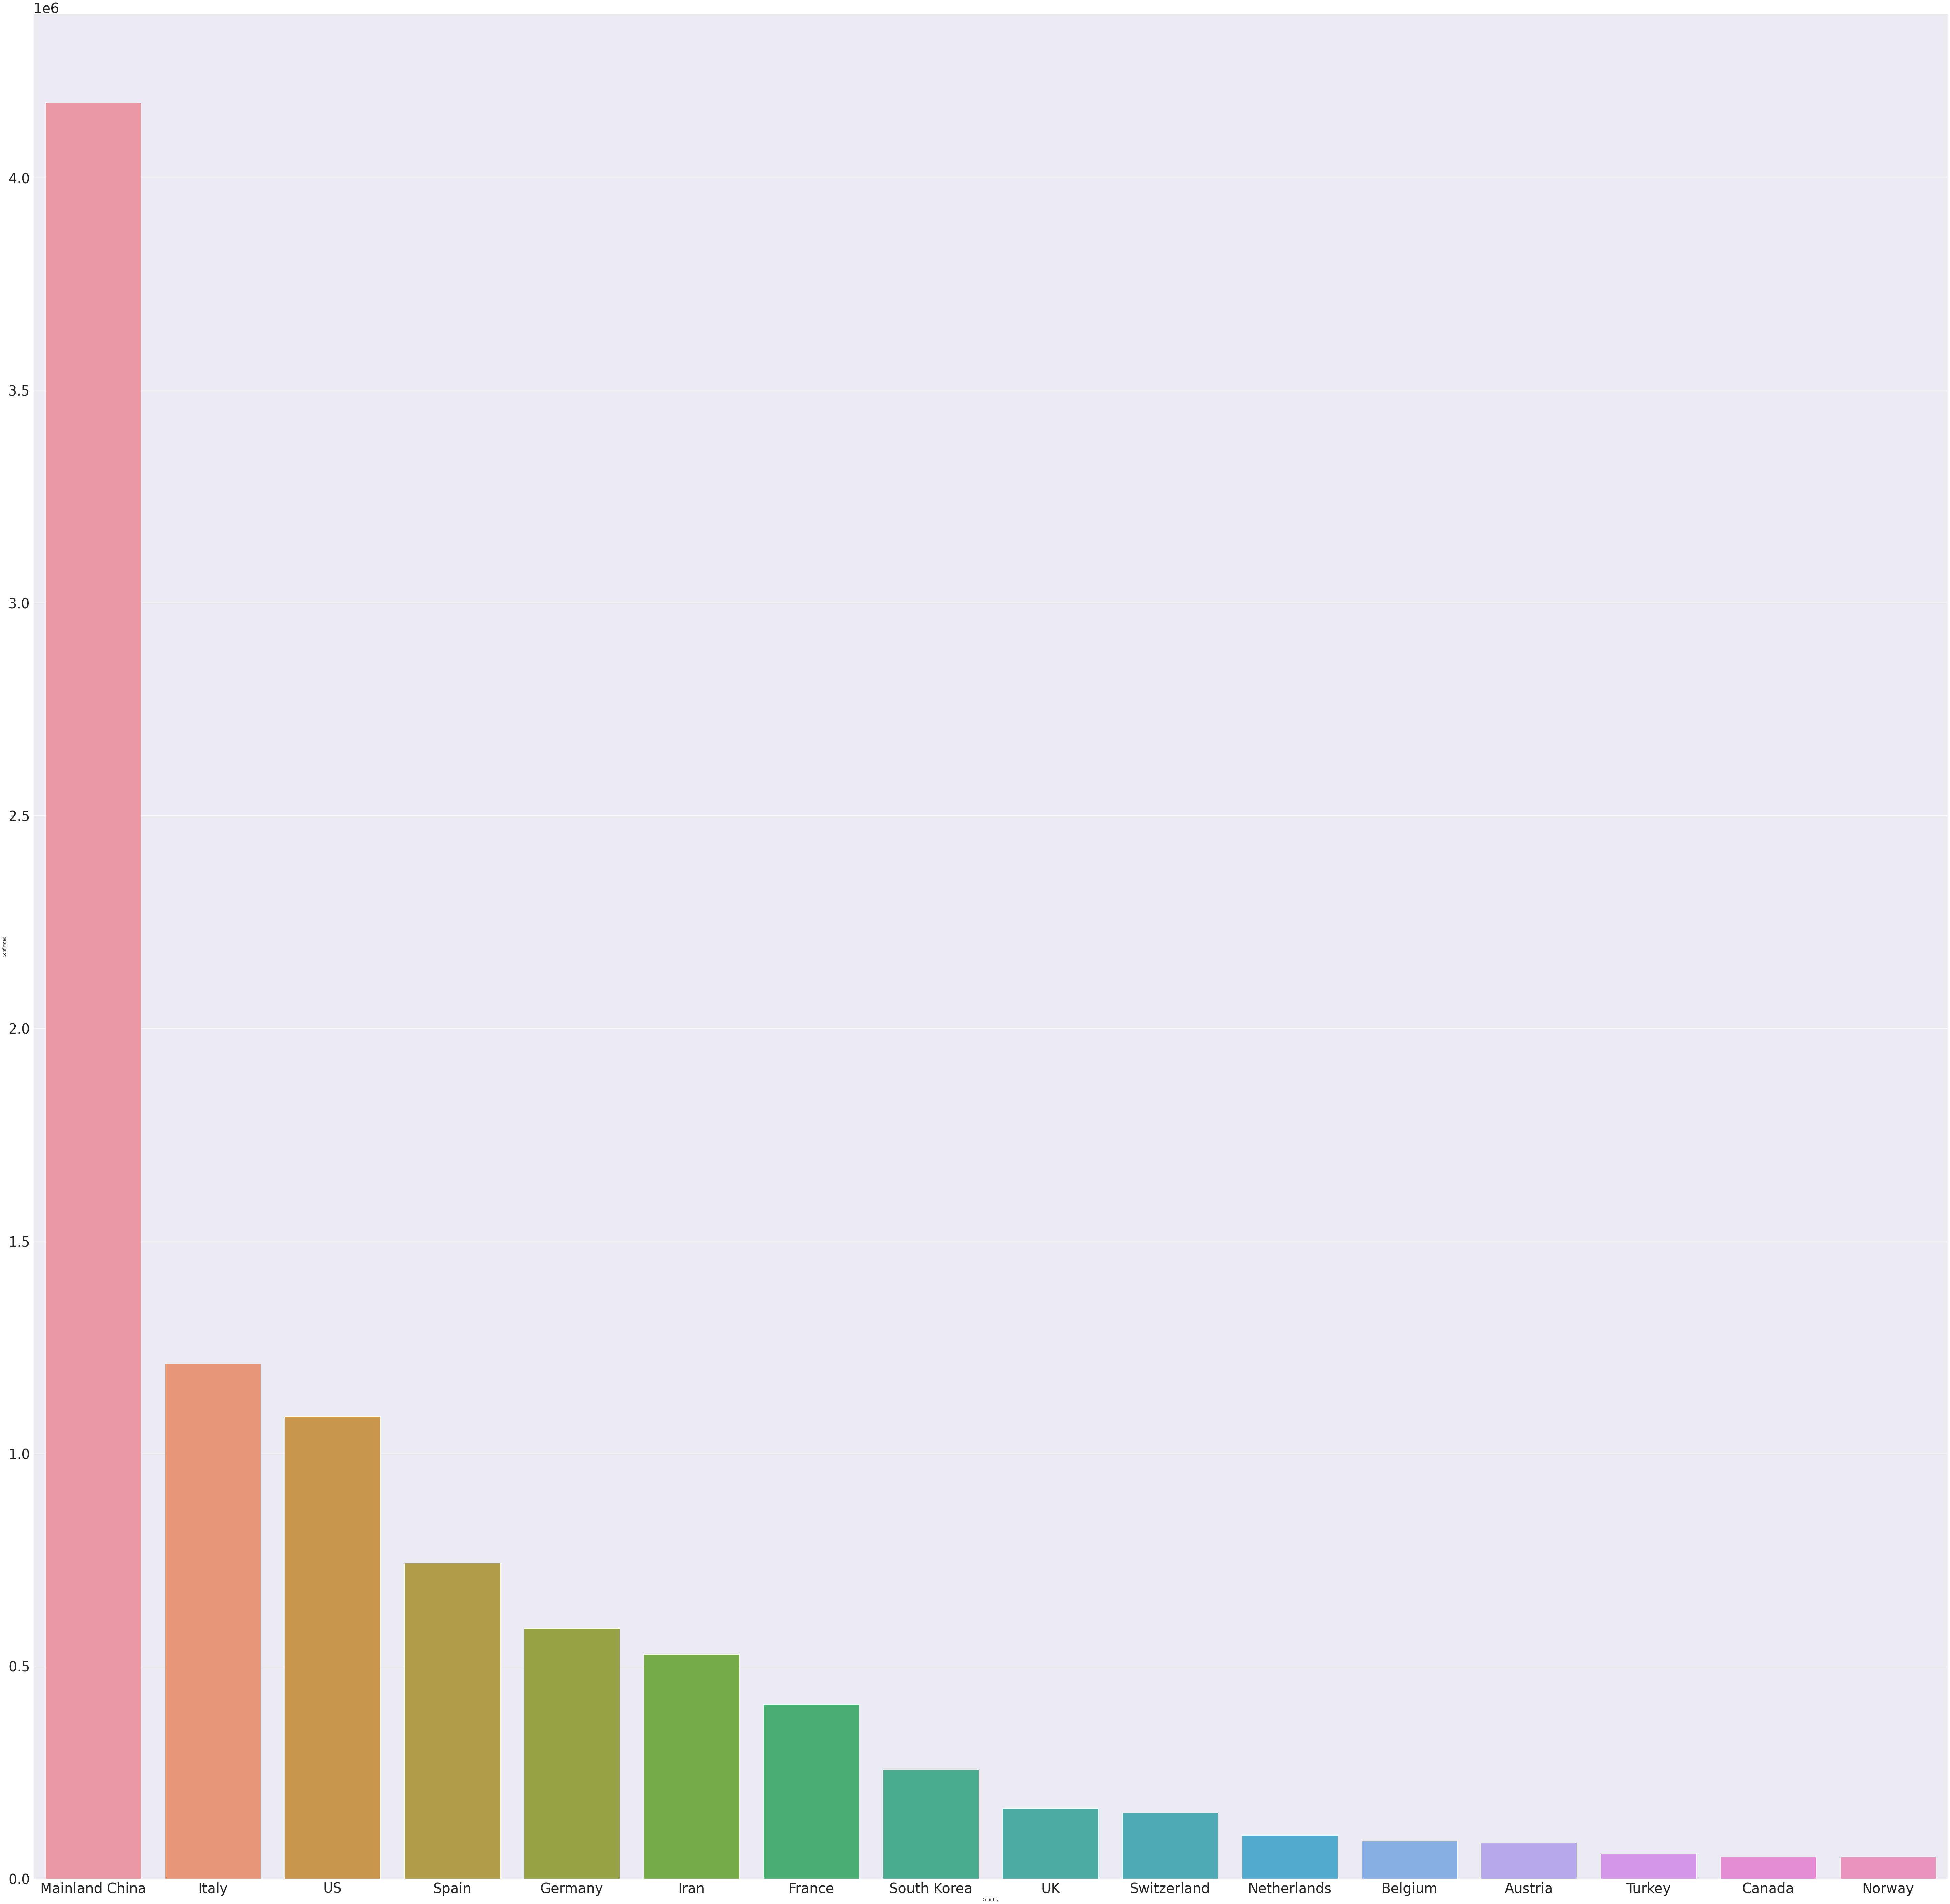

In [47]:
sns.set(rc={'figure.figsize':(100,100)})
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40)
sns.barplot(data = cdf, x = "Country", y = "Confirmed")
plt.show()

We obseve that these 15 countries account to 92% of the confirmed cases worldwide from the given data, out of which China accounts to about 43% of the cases as derived from the pie chart.

# **Part 4**
## Predicting Cases for only Asian Countries

In [48]:
df = copy.deepcopy(df_orig)
df.drop('Last Update',inplace=True,axis=1)
date_lst  = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp
asia_df = pd.DataFrame(df).set_index("SNo")
asia_df

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
SNo,,,,,,
1,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...
10667,03/31/2020,Wyoming,US,109.0,0.0,0.0
10668,03/31/2020,Xinjiang,Mainland China,76.0,3.0,73.0
10669,03/31/2020,Yukon,Canada,5.0,0.0,0.0


In [49]:
d = pd.DataFrame(asia_df["Country/Region"].value_counts())
d.sort_index(inplace =True)

d

,Country/Region
Azerbaijan,1
"('St. Martin',)",1
Afghanistan,37
Albania,23
Algeria,36
...,...
Vietnam,69
West Bank and Gaza,6
Zambia,14
Zimbabwe,12


In [50]:
countries = [
{'timezones': ['Europe/Andorra'], 'code': 'AD', 'continent': 'Europe', 'name': 'Andorra', 'capital': 'Andorra la Vella'},
{'timezones': ['Asia/Kabul'], 'code': 'AF', 'continent': 'Asia', 'name': 'Afghanistan', 'capital': 'Kabul'},
{'timezones': ['America/Antigua'], 'code': 'AG', 'continent': 'North America', 'name': 'Antigua and Barbuda', 'capital': "St. John's"},
{'timezones': ['Europe/Tirane'], 'code': 'AL', 'continent': 'Europe', 'name': 'Albania', 'capital': 'Tirana'},
{'timezones': ['Asia/Yerevan'], 'code': 'AM', 'continent': 'Asia', 'name': 'Armenia', 'capital': 'Yerevan'},
{'timezones': ['Africa/Luanda'], 'code': 'AO', 'continent': 'Africa', 'name': 'Angola', 'capital': 'Luanda'},
{'timezones': ['America/Argentina/Buenos_Aires', 'America/Argentina/Cordoba', 'America/Argentina/Jujuy', 'America/Argentina/Tucuman', 'America/Argentina/Catamarca', 'America/Argentina/La_Rioja', 'America/Argentina/San_Juan', 'America/Argentina/Mendoza', 'America/Argentina/Rio_Gallegos', 'America/Argentina/Ushuaia'], 'code': 'AR', 'continent': 'South America', 'name': 'Argentina', 'capital': 'Buenos Aires'},
{'timezones': ['Europe/Vienna'], 'code': 'AT', 'continent': 'Europe', 'name': 'Austria', 'capital': 'Vienna'},
{'timezones': ['Australia/Lord_Howe', 'Australia/Hobart', 'Australia/Currie', 'Australia/Melbourne', 'Australia/Sydney', 'Australia/Broken_Hill', 'Australia/Brisbane', 'Australia/Lindeman', 'Australia/Adelaide', 'Australia/Darwin', 'Australia/Perth'], 'code': 'AU', 'continent': 'Oceania', 'name': 'Australia', 'capital': 'Canberra'},
{'timezones': ['Asia/Baku'], 'code': 'AZ', 'continent': 'Asia', 'name': 'Azerbaijan', 'capital': 'Baku'},
{'timezones': ['America/Barbados'], 'code': 'BB', 'continent': 'North America', 'name': 'Barbados', 'capital': 'Bridgetown'},
{'timezones': ['Asia/Dhaka'], 'code': 'BD', 'continent': 'Asia', 'name': 'Bangladesh', 'capital': 'Dhaka'},
{'timezones': ['Europe/Brussels'], 'code': 'BE', 'continent': 'Europe', 'name': 'Belgium', 'capital': 'Brussels'},
{'timezones': ['Africa/Ouagadougou'], 'code': 'BF', 'continent': 'Africa', 'name': 'Burkina Faso', 'capital': 'Ouagadougou'},
{'timezones': ['Europe/Sofia'], 'code': 'BG', 'continent': 'Europe', 'name': 'Bulgaria', 'capital': 'Sofia'},
{'timezones': ['Asia/Bahrain'], 'code': 'BH', 'continent': 'Asia', 'name': 'Bahrain', 'capital': 'Manama'},
{'timezones': ['Africa/Bujumbura'], 'code': 'BI', 'continent': 'Africa', 'name': 'Burundi', 'capital': 'Bujumbura'},
{'timezones': ['Africa/Porto-Novo'], 'code': 'BJ', 'continent': 'Africa', 'name': 'Benin', 'capital': 'Porto-Novo'},
{'timezones': ['Asia/Brunei'], 'code': 'BN', 'continent': 'Asia', 'name': 'Brunei Darussalam', 'capital': 'Bandar Seri Begawan'},
{'timezones': ['America/La_Paz'], 'code': 'BO', 'continent': 'South America', 'name': 'Bolivia', 'capital': 'Sucre'},
{'timezones': ['America/Noronha', 'America/Belem', 'America/Fortaleza', 'America/Recife', 'America/Araguaina', 'America/Maceio', 'America/Bahia', 'America/Sao_Paulo', 'America/Campo_Grande', 'America/Cuiaba', 'America/Porto_Velho', 'America/Boa_Vista', 'America/Manaus', 'America/Eirunepe', 'America/Rio_Branco'], 'code': 'BR', 'continent': 'South America', 'name': 'Brazil', 'capital': 'Bras\xc3\xadlia'},
{'timezones': ['America/Nassau'], 'code': 'BS', 'continent': 'North America', 'name': 'Bahamas', 'capital': 'Nassau'},
{'timezones': ['Asia/Thimphu'], 'code': 'BT', 'continent': 'Asia', 'name': 'Bhutan', 'capital': 'Thimphu'},
{'timezones': ['Africa/Gaborone'], 'code': 'BW', 'continent': 'Africa', 'name': 'Botswana', 'capital': 'Gaborone'},
{'timezones': ['Europe/Minsk'], 'code': 'BY', 'continent': 'Europe', 'name': 'Belarus', 'capital': 'Minsk'},
{'timezones': ['America/Belize'], 'code': 'BZ', 'continent': 'North America', 'name': 'Belize', 'capital': 'Belmopan'},
{'timezones': ['America/St_Johns', 'America/Halifax', 'America/Glace_Bay', 'America/Moncton', 'America/Goose_Bay', 'America/Blanc-Sablon', 'America/Montreal', 'America/Toronto', 'America/Nipigon', 'America/Thunder_Bay', 'America/Pangnirtung', 'America/Iqaluit', 'America/Atikokan', 'America/Rankin_Inlet', 'America/Winnipeg', 'America/Rainy_River', 'America/Cambridge_Bay', 'America/Regina', 'America/Swift_Current', 'America/Edmonton', 'America/Yellowknife', 'America/Inuvik', 'America/Dawson_Creek', 'America/Vancouver', 'America/Whitehorse', 'America/Dawson'], 'code': 'CA', 'continent': 'North America', 'name': 'Canada', 'capital': 'Ottawa'},
{'timezones': ['Africa/Kinshasa', 'Africa/Lubumbashi'], 'code': 'CD', 'continent': 'Africa', 'name': 'Democratic Republic of the Congo', 'capital': 'Kinshasa'},
{'timezones': ['Africa/Brazzaville'], 'code': 'CG', 'continent': 'Africa', 'name': 'Republic of the Congo', 'capital': 'Brazzaville'},
{'timezones': ['Africa/Abidjan'], 'code': 'CI', 'continent': 'Africa', 'name': "C\xc3\xb4te d'Ivoire", 'capital': 'Yamoussoukro'},
{'timezones': ['America/Santiago', 'Pacific/Easter'], 'code': 'CL', 'continent': 'South America', 'name': 'Chile', 'capital': 'Santiago'},
{'timezones': ['Africa/Douala'], 'code': 'CM', 'continent': 'Africa', 'name': 'Cameroon', 'capital': 'Yaound\xc3\xa9'},
{'timezones': ['Asia/Shanghai', 'Asia/Harbin', 'Asia/Chongqing', 'Asia/Urumqi', 'Asia/Kashgar'], 'code': 'CN', 'continent': 'Asia', 'name': "People's Republic of China", 'capital': 'Beijing'},
{'timezones': ['America/Bogota'], 'code': 'CO', 'continent': 'South America', 'name': 'Colombia', 'capital': 'Bogot\xc3\xa1'},
{'timezones': ['America/Costa_Rica'], 'code': 'CR', 'continent': 'North America', 'name': 'Costa Rica', 'capital': 'San Jos\xc3\xa9'},
{'timezones': ['America/Havana'], 'code': 'CU', 'continent': 'North America', 'name': 'Cuba', 'capital': 'Havana'},
{'timezones': ['Atlantic/Cape_Verde'], 'code': 'CV', 'continent': 'Africa', 'name': 'Cape Verde', 'capital': 'Praia'},
{'timezones': ['Asia/Nicosia'], 'code': 'CY', 'continent': 'Asia', 'name': 'Cyprus', 'capital': 'Nicosia'},
{'timezones': ['Europe/Prague'], 'code': 'CZ', 'continent': 'Europe', 'name': 'Czech Republic', 'capital': 'Prague'},
{'timezones': ['Europe/Berlin'], 'code': 'DE', 'continent': 'Europe', 'name': 'Germany', 'capital': 'Berlin'},
{'timezones': ['Africa/Djibouti'], 'code': 'DJ', 'continent': 'Africa', 'name': 'Djibouti', 'capital': 'Djibouti City'},
{'timezones': ['Europe/Copenhagen'], 'code': 'DK', 'continent': 'Europe', 'name': 'Denmark', 'capital': 'Copenhagen'},
{'timezones': ['America/Dominica'], 'code': 'DM', 'continent': 'North America', 'name': 'Dominica', 'capital': 'Roseau'},
{'timezones': ['America/Santo_Domingo'], 'code': 'DO', 'continent': 'North America', 'name': 'Dominican Republic', 'capital': 'Santo Domingo'},
{'timezones': ['America/Guayaquil', 'Pacific/Galapagos'], 'code': 'EC', 'continent': 'South America', 'name': 'Ecuador', 'capital': 'Quito'},
{'timezones': ['Europe/Tallinn'], 'code': 'EE', 'continent': 'Europe', 'name': 'Estonia', 'capital': 'Tallinn'},
{'timezones': ['Africa/Cairo'], 'code': 'EG', 'continent': 'Africa', 'name': 'Egypt', 'capital': 'Cairo'},
{'timezones': ['Africa/Asmera'], 'code': 'ER', 'continent': 'Africa', 'name': 'Eritrea', 'capital': 'Asmara'},
{'timezones': ['Africa/Addis_Ababa'], 'code': 'ET', 'continent': 'Africa', 'name': 'Ethiopia', 'capital': 'Addis Ababa'},
{'timezones': ['Europe/Helsinki'], 'code': 'FI', 'continent': 'Europe', 'name': 'Finland', 'capital': 'Helsinki'},
{'timezones': ['Pacific/Fiji'], 'code': 'FJ', 'continent': 'Oceania', 'name': 'Fiji', 'capital': 'Suva'},
{'timezones': ['Europe/Paris'], 'code': 'FR', 'continent': 'Europe', 'name': 'France', 'capital': 'Paris'},
{'timezones': ['Africa/Libreville'], 'code': 'GA', 'continent': 'Africa', 'name': 'Gabon', 'capital': 'Libreville'},
{'timezones': ['Asia/Tbilisi'], 'code': 'GE', 'continent': 'Asia', 'name': 'Georgia', 'capital': 'Tbilisi'},
{'timezones': ['Africa/Accra'], 'code': 'GH', 'continent': 'Africa', 'name': 'Ghana', 'capital': 'Accra'},
{'timezones': ['Africa/Banjul'], 'code': 'GM', 'continent': 'Africa', 'name': 'The Gambia', 'capital': 'Banjul'},
{'timezones': ['Africa/Conakry'], 'code': 'GN', 'continent': 'Africa', 'name': 'Guinea', 'capital': 'Conakry'},
{'timezones': ['Europe/Athens'], 'code': 'GR', 'continent': 'Europe', 'name': 'Greece', 'capital': 'Athens'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Guatemala', 'capital': 'Guatemala City'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Haiti', 'capital': 'Port-au-Prince'},
{'timezones': ['Africa/Bissau'], 'code': 'GW', 'continent': 'Africa', 'name': 'Guinea-Bissau', 'capital': 'Bissau'},
{'timezones': ['America/Guyana'], 'code': 'GY', 'continent': 'South America', 'name': 'Guyana', 'capital': 'Georgetown'},
{'timezones': ['America/Tegucigalpa'], 'code': 'HN', 'continent': 'North America', 'name': 'Honduras', 'capital': 'Tegucigalpa'},
{'timezones': ['Europe/Budapest'], 'code': 'HU', 'continent': 'Europe', 'name': 'Hungary', 'capital': 'Budapest'},
{'timezones': ['Asia/Jakarta', 'Asia/Pontianak', 'Asia/Makassar', 'Asia/Jayapura'], 'code': 'ID', 'continent': 'Asia', 'name': 'Indonesia', 'capital': 'Jakarta'},
{'timezones': ['Europe/Dublin'], 'code': 'IE', 'continent': 'Europe', 'name': 'Republic of Ireland', 'capital': 'Dublin'},
{'timezones': ['Asia/Jerusalem'], 'code': 'IL', 'continent': 'Asia', 'name': 'Israel', 'capital': 'Jerusalem'},
{'timezones': ['Asia/Calcutta'], 'code': 'IN', 'continent': 'Asia', 'name': 'India', 'capital': 'New Delhi'},
{'timezones': ['Asia/Baghdad'], 'code': 'IQ', 'continent': 'Asia', 'name': 'Iraq', 'capital': 'Baghdad'},
{'timezones': ['Asia/Tehran'], 'code': 'IR', 'continent': 'Asia', 'name': 'Iran', 'capital': 'Tehran'},
{'timezones': ['Atlantic/Reykjavik'], 'code': 'IS', 'continent': 'Europe', 'name': 'Iceland', 'capital': 'Reykjav\xc3\xadk'},
{'timezones': ['Europe/Rome'], 'code': 'IT', 'continent': 'Europe', 'name': 'Italy', 'capital': 'Rome'},
{'timezones': ['America/Jamaica'], 'code': 'JM', 'continent': 'North America', 'name': 'Jamaica', 'capital': 'Kingston'},
{'timezones': ['Asia/Amman'], 'code': 'JO', 'continent': 'Asia', 'name': 'Jordan', 'capital': 'Amman'},
{'timezones': ['Asia/Tokyo'], 'code': 'JP', 'continent': 'Asia', 'name': 'Japan', 'capital': 'Tokyo'},
{'timezones': ['Africa/Nairobi'], 'code': 'KE', 'continent': 'Africa', 'name': 'Kenya', 'capital': 'Nairobi'},
{'timezones': ['Asia/Bishkek'], 'code': 'KG', 'continent': 'Asia', 'name': 'Kyrgyzstan', 'capital': 'Bishkek'},
{'timezones': ['Pacific/Tarawa', 'Pacific/Enderbury', 'Pacific/Kiritimati'], 'code': 'KI', 'continent': 'Oceania', 'name': 'Kiribati', 'capital': 'Tarawa'},
{'timezones': ['Asia/Pyongyang'], 'code': 'KP', 'continent': 'Asia', 'name': 'North Korea', 'capital': 'Pyongyang'},
{'timezones': ['Asia/Seoul'], 'code': 'KR', 'continent': 'Asia', 'name': 'South Korea', 'capital': 'Seoul'},
{'timezones': ['Asia/Kuwait'], 'code': 'KW', 'continent': 'Asia', 'name': 'Kuwait', 'capital': 'Kuwait City'},
{'timezones': ['Asia/Beirut'], 'code': 'LB', 'continent': 'Asia', 'name': 'Lebanon', 'capital': 'Beirut'},
{'timezones': ['Europe/Vaduz'], 'code': 'LI', 'continent': 'Europe', 'name': 'Liechtenstein', 'capital': 'Vaduz'},
{'timezones': ['Africa/Monrovia'], 'code': 'LR', 'continent': 'Africa', 'name': 'Liberia', 'capital': 'Monrovia'},
{'timezones': ['Africa/Maseru'], 'code': 'LS', 'continent': 'Africa', 'name': 'Lesotho', 'capital': 'Maseru'},
{'timezones': ['Europe/Vilnius'], 'code': 'LT', 'continent': 'Europe', 'name': 'Lithuania', 'capital': 'Vilnius'},
{'timezones': ['Europe/Luxembourg'], 'code': 'LU', 'continent': 'Europe', 'name': 'Luxembourg', 'capital': 'Luxembourg City'},
{'timezones': ['Europe/Riga'], 'code': 'LV', 'continent': 'Europe', 'name': 'Latvia', 'capital': 'Riga'},
{'timezones': ['Africa/Tripoli'], 'code': 'LY', 'continent': 'Africa', 'name': 'Libya', 'capital': 'Tripoli'},
{'timezones': ['Indian/Antananarivo'], 'code': 'MG', 'continent': 'Africa', 'name': 'Madagascar', 'capital': 'Antananarivo'},
{'timezones': ['Pacific/Majuro', 'Pacific/Kwajalein'], 'code': 'MH', 'continent': 'Oceania', 'name': 'Marshall Islands', 'capital': 'Majuro'},
{'timezones': ['Europe/Skopje'], 'code': 'MK', 'continent': 'Europe', 'name': 'Macedonia', 'capital': 'Skopje'},
{'timezones': ['Africa/Bamako'], 'code': 'ML', 'continent': 'Africa', 'name': 'Mali', 'capital': 'Bamako'},
{'timezones': ['Asia/Rangoon'], 'code': 'MM', 'continent': 'Asia', 'name': 'Myanmar', 'capital': 'Naypyidaw'},
{'timezones': ['Asia/Ulaanbaatar', 'Asia/Hovd', 'Asia/Choibalsan'], 'code': 'MN', 'continent': 'Asia', 'name': 'Mongolia', 'capital': 'Ulaanbaatar'},
{'timezones': ['Africa/Nouakchott'], 'code': 'MR', 'continent': 'Africa', 'name': 'Mauritania', 'capital': 'Nouakchott'},
{'timezones': ['Europe/Malta'], 'code': 'MT', 'continent': 'Europe', 'name': 'Malta', 'capital': 'Valletta'},
{'timezones': ['Indian/Mauritius'], 'code': 'MU', 'continent': 'Africa', 'name': 'Mauritius', 'capital': 'Port Louis'},
{'timezones': ['Indian/Maldives'], 'code': 'MV', 'continent': 'Asia', 'name': 'Maldives', 'capital': 'Mal\xc3\xa9'},
{'timezones': ['Africa/Blantyre'], 'code': 'MW', 'continent': 'Africa', 'name': 'Malawi', 'capital': 'Lilongwe'},
{'timezones': ['America/Mexico_City', 'America/Cancun', 'America/Merida', 'America/Monterrey', 'America/Mazatlan', 'America/Chihuahua', 'America/Hermosillo', 'America/Tijuana'], 'code': 'MX', 'continent': 'North America', 'name': 'Mexico', 'capital': 'Mexico City'},
{'timezones': ['Asia/Kuala_Lumpur', 'Asia/Kuching'], 'code': 'MY', 'continent': 'Asia', 'name': 'Malaysia', 'capital': 'Kuala Lumpur'},
{'timezones': ['Africa/Maputo'], 'code': 'MZ', 'continent': 'Africa', 'name': 'Mozambique', 'capital': 'Maputo'},
{'timezones': ['Africa/Windhoek'], 'code': 'NA', 'continent': 'Africa', 'name': 'Namibia', 'capital': 'Windhoek'},
{'timezones': ['Africa/Niamey'], 'code': 'NE', 'continent': 'Africa', 'name': 'Niger', 'capital': 'Niamey'},
{'timezones': ['Africa/Lagos'], 'code': 'NG', 'continent': 'Africa', 'name': 'Nigeria', 'capital': 'Abuja'},
{'timezones': ['America/Managua'], 'code': 'NI', 'continent': 'North America', 'name': 'Nicaragua', 'capital': 'Managua'},
{'timezones': ['Europe/Amsterdam'], 'code': 'NL', 'continent': 'Europe', 'name': 'Kingdom of the Netherlands', 'capital': 'Amsterdam'},
{'timezones': ['Europe/Oslo'], 'code': 'NO', 'continent': 'Europe', 'name': 'Norway', 'capital': 'Oslo'},
{'timezones': ['Asia/Katmandu'], 'code': 'NP', 'continent': 'Asia', 'name': 'Nepal', 'capital': 'Kathmandu'},
{'timezones': ['Pacific/Nauru'], 'code': 'NR', 'continent': 'Oceania', 'name': 'Nauru', 'capital': 'Yaren'},
{'timezones': ['Pacific/Auckland', 'Pacific/Chatham'], 'code': 'NZ', 'continent': 'Oceania', 'name': 'New Zealand', 'capital': 'Wellington'},
{'timezones': ['Asia/Muscat'], 'code': 'OM', 'continent': 'Asia', 'name': 'Oman', 'capital': 'Muscat'},
{'timezones': ['America/Panama'], 'code': 'PA', 'continent': 'North America', 'name': 'Panama', 'capital': 'Panama City'},
{'timezones': ['America/Lima'], 'code': 'PE', 'continent': 'South America', 'name': 'Peru', 'capital': 'Lima'},
{'timezones': ['Pacific/Port_Moresby'], 'code': 'PG', 'continent': 'Oceania', 'name': 'Papua New Guinea', 'capital': 'Port Moresby'},
{'timezones': ['Asia/Manila'], 'code': 'PH', 'continent': 'Asia', 'name': 'Philippines', 'capital': 'Manila'},
{'timezones': ['Asia/Karachi'], 'code': 'PK', 'continent': 'Asia', 'name': 'Pakistan', 'capital': 'Islamabad'},
{'timezones': ['Europe/Warsaw'], 'code': 'PL', 'continent': 'Europe', 'name': 'Poland', 'capital': 'Warsaw'},
{'timezones': ['Europe/Lisbon', 'Atlantic/Madeira', 'Atlantic/Azores'], 'code': 'PT', 'continent': 'Europe', 'name': 'Portugal', 'capital': 'Lisbon'},
{'timezones': ['Pacific/Palau'], 'code': 'PW', 'continent': 'Oceania', 'name': 'Palau', 'capital': 'Ngerulmud'},
{'timezones': ['America/Asuncion'], 'code': 'PY', 'continent': 'South America', 'name': 'Paraguay', 'capital': 'Asunci\xc3\xb3n'},
{'timezones': ['Asia/Qatar'], 'code': 'QA', 'continent': 'Asia', 'name': 'Qatar', 'capital': 'Doha'},
{'timezones': ['Europe/Bucharest'], 'code': 'RO', 'continent': 'Europe', 'name': 'Romania', 'capital': 'Bucharest'},
{'timezones': ['Europe/Kaliningrad', 'Europe/Moscow', 'Europe/Volgograd', 'Europe/Samara', 'Asia/Yekaterinburg', 'Asia/Omsk', 'Asia/Novosibirsk', 'Asia/Krasnoyarsk', 'Asia/Irkutsk', 'Asia/Yakutsk', 'Asia/Vladivostok', 'Asia/Sakhalin', 'Asia/Magadan', 'Asia/Kamchatka', 'Asia/Anadyr'], 'code': 'RU', 'continent': 'Europe', 'name': 'Russia', 'capital': 'Moscow'},
{'timezones': ['Africa/Kigali'], 'code': 'RW', 'continent': 'Africa', 'name': 'Rwanda', 'capital': 'Kigali'},
{'timezones': ['Asia/Riyadh'], 'code': 'SA', 'continent': 'Asia', 'name': 'Saudi Arabia', 'capital': 'Riyadh'},
{'timezones': ['Pacific/Guadalcanal'], 'code': 'SB', 'continent': 'Oceania', 'name': 'Solomon Islands', 'capital': 'Honiara'},
{'timezones': ['Indian/Mahe'], 'code': 'SC', 'continent': 'Africa', 'name': 'Seychelles', 'capital': 'Victoria'},
{'timezones': ['Africa/Khartoum'], 'code': 'SD', 'continent': 'Africa', 'name': 'Sudan', 'capital': 'Khartoum'},
{'timezones': ['Europe/Stockholm'], 'code': 'SE', 'continent': 'Europe', 'name': 'Sweden', 'capital': 'Stockholm'},
{'timezones': ['Asia/Singapore'], 'code': 'SG', 'continent': 'Asia', 'name': 'Singapore', 'capital': 'Singapore'},
{'timezones': ['Europe/Ljubljana'], 'code': 'SI', 'continent': 'Europe', 'name': 'Slovenia', 'capital': 'Ljubljana'},
{'timezones': ['Europe/Bratislava'], 'code': 'SK', 'continent': 'Europe', 'name': 'Slovakia', 'capital': 'Bratislava'},
{'timezones': ['Africa/Freetown'], 'code': 'SL', 'continent': 'Africa', 'name': 'Sierra Leone', 'capital': 'Freetown'},
{'timezones': ['Europe/San_Marino'], 'code': 'SM', 'continent': 'Europe', 'name': 'San Marino', 'capital': 'San Marino'},
{'timezones': ['Africa/Dakar'], 'code': 'SN', 'continent': 'Africa', 'name': 'Senegal', 'capital': 'Dakar'},
{'timezones': ['Africa/Mogadishu'], 'code': 'SO', 'continent': 'Africa', 'name': 'Somalia', 'capital': 'Mogadishu'},
{'timezones': ['America/Paramaribo'], 'code': 'SR', 'continent': 'South America', 'name': 'Suriname', 'capital': 'Paramaribo'},
{'timezones': ['Africa/Sao_Tome'], 'code': 'ST', 'continent': 'Africa', 'name': 'S\xc3\xa3o Tom\xc3\xa9 and Pr\xc3\xadncipe', 'capital': 'S\xc3\xa3o Tom\xc3\xa9'},
{'timezones': ['Asia/Damascus'], 'code': 'SY', 'continent': 'Asia', 'name': 'Syria', 'capital': 'Damascus'},
{'timezones': ['Africa/Lome'], 'code': 'TG', 'continent': 'Africa', 'name': 'Togo', 'capital': 'Lom\xc3\xa9'},
{'timezones': ['Asia/Bangkok'], 'code': 'TH', 'continent': 'Asia', 'name': 'Thailand', 'capital': 'Bangkok'},
{'timezones': ['Asia/Dushanbe'], 'code': 'TJ', 'continent': 'Asia', 'name': 'Tajikistan', 'capital': 'Dushanbe'},
{'timezones': ['Asia/Ashgabat'], 'code': 'TM', 'continent': 'Asia', 'name': 'Turkmenistan', 'capital': 'Ashgabat'},
{'timezones': ['Africa/Tunis'], 'code': 'TN', 'continent': 'Africa', 'name': 'Tunisia', 'capital': 'Tunis'},
{'timezones': ['Pacific/Tongatapu'], 'code': 'TO', 'continent': 'Oceania', 'name': 'Tonga', 'capital': 'Nuku\xca\xbbalofa'},
{'timezones': ['Europe/Istanbul'], 'code': 'TR', 'continent': 'Asia', 'name': 'Turkey', 'capital': 'Ankara'},
{'timezones': ['America/Port_of_Spain'], 'code': 'TT', 'continent': 'North America', 'name': 'Trinidad and Tobago', 'capital': 'Port of Spain'},
{'timezones': ['Pacific/Funafuti'], 'code': 'TV', 'continent': 'Oceania', 'name': 'Tuvalu', 'capital': 'Funafuti'},
{'timezones': ['Africa/Dar_es_Salaam'], 'code': 'TZ', 'continent': 'Africa', 'name': 'Tanzania', 'capital': 'Dodoma'},
{'timezones': ['Europe/Kiev', 'Europe/Uzhgorod', 'Europe/Zaporozhye', 'Europe/Simferopol'], 'code': 'UA', 'continent': 'Europe', 'name': 'Ukraine', 'capital': 'Kyiv'},
{'timezones': ['Africa/Kampala'], 'code': 'UG', 'continent': 'Africa', 'name': 'Uganda', 'capital': 'Kampala'},
{'timezones': ['America/New_York', 'America/Detroit', 'America/Kentucky/Louisville', 'America/Kentucky/Monticello', 'America/Indiana/Indianapolis', 'America/Indiana/Marengo', 'America/Indiana/Knox', 'America/Indiana/Vevay', 'America/Chicago', 'America/Indiana/Vincennes', 'America/Indiana/Petersburg', 'America/Menominee', 'America/North_Dakota/Center', 'America/North_Dakota/New_Salem', 'America/Denver', 'America/Boise', 'America/Shiprock', 'America/Phoenix', 'America/Los_Angeles', 'America/Anchorage', 'America/Juneau', 'America/Yakutat', 'America/Nome', 'America/Adak', 'Pacific/Honolulu'], 'code': 'US', 'continent': 'North America', 'name': 'United States', 'capital': 'Washington, D.C.'},
{'timezones': ['America/Montevideo'], 'code': 'UY', 'continent': 'South America', 'name': 'Uruguay', 'capital': 'Montevideo'},
{'timezones': ['Asia/Samarkand', 'Asia/Tashkent'], 'code': 'UZ', 'continent': 'Asia', 'name': 'Uzbekistan', 'capital': 'Tashkent'},
{'timezones': ['Europe/Vatican'], 'code': 'VA', 'continent': 'Europe', 'name': 'Vatican City', 'capital': 'Vatican City'},
{'timezones': ['America/Caracas'], 'code': 'VE', 'continent': 'South America', 'name': 'Venezuela', 'capital': 'Caracas'},
{'timezones': ['Asia/Saigon'], 'code': 'VN', 'continent': 'Asia', 'name': 'Vietnam', 'capital': 'Hanoi'},
{'timezones': ['Pacific/Efate'], 'code': 'VU', 'continent': 'Oceania', 'name': 'Vanuatu', 'capital': 'Port Vila'},
{'timezones': ['Asia/Aden'], 'code': 'YE', 'continent': 'Asia', 'name': 'Yemen', 'capital': "Sana'a"},
{'timezones': ['Africa/Lusaka'], 'code': 'ZM', 'continent': 'Africa', 'name': 'Zambia', 'capital': 'Lusaka'},
{'timezones': ['Africa/Harare'], 'code': 'ZW', 'continent': 'Africa', 'name': 'Zimbabwe', 'capital': 'Harare'},
{'timezones': ['Africa/Algiers'], 'code': 'DZ', 'continent': 'Africa', 'name': 'Algeria', 'capital': 'Algiers'},
{'timezones': ['Europe/Sarajevo'], 'code': 'BA', 'continent': 'Europe', 'name': 'Bosnia and Herzegovina', 'capital': 'Sarajevo'},
{'timezones': ['Asia/Phnom_Penh'], 'code': 'KH', 'continent': 'Asia', 'name': 'Cambodia', 'capital': 'Phnom Penh'},
{'timezones': ['Africa/Bangui'], 'code': 'CF', 'continent': 'Africa', 'name': 'Central African Republic', 'capital': 'Bangui'},
{'timezones': ['Africa/Ndjamena'], 'code': 'TD', 'continent': 'Africa', 'name': 'Chad', 'capital': "N'Djamena"},
{'timezones': ['Indian/Comoro'], 'code': 'KM', 'continent': 'Africa', 'name': 'Comoros', 'capital': 'Moroni'},
{'timezones': ['Europe/Zagreb'], 'code': 'HR', 'continent': 'Europe', 'name': 'Croatia', 'capital': 'Zagreb'},
{'timezones': ['Asia/Dili'], 'code': 'TL', 'continent': 'Asia', 'name': 'East Timor', 'capital': 'Dili'},
{'timezones': ['America/El_Salvador'], 'code': 'SV', 'continent': 'North America', 'name': 'El Salvador', 'capital': 'San Salvador'},
{'timezones': ['Africa/Malabo'], 'code': 'GQ', 'continent': 'Africa', 'name': 'Equatorial Guinea', 'capital': 'Malabo'},
{'timezones': ['America/Grenada'], 'code': 'GD', 'continent': 'North America', 'name': 'Grenada', 'capital': "St. George's"},
{'timezones': ['Asia/Almaty', 'Asia/Qyzylorda', 'Asia/Aqtobe', 'Asia/Aqtau', 'Asia/Oral'], 'code': 'KZ', 'continent': 'Asia', 'name': 'Kazakhstan', 'capital': 'Astana'},
{'timezones': ['Asia/Vientiane'], 'code': 'LA', 'continent': 'Asia', 'name': 'Laos', 'capital': 'Vientiane'},
{'timezones': ['Pacific/Truk', 'Pacific/Ponape', 'Pacific/Kosrae'], 'code': 'FM', 'continent': 'Oceania', 'name': 'Federated States of Micronesia', 'capital': 'Palikir'},
{'timezones': ['Europe/Chisinau'], 'code': 'MD', 'continent': 'Europe', 'name': 'Moldova', 'capital': 'Chi\xc5\x9fin\xc4\x83u'},
{'timezones': ['Europe/Monaco'], 'code': 'MC', 'continent': 'Europe', 'name': 'Monaco', 'capital': 'Monaco'},
{'timezones': ['Europe/Podgorica'], 'code': 'ME', 'continent': 'Europe', 'name': 'Montenegro', 'capital': 'Podgorica'},
{'timezones': ['Africa/Casablanca'], 'code': 'MA', 'continent': 'Africa', 'name': 'Morocco', 'capital': 'Rabat'},
{'timezones': ['America/St_Kitts'], 'code': 'KN', 'continent': 'North America', 'name': 'Saint Kitts and Nevis', 'capital': 'Basseterre'},
{'timezones': ['America/St_Lucia'], 'code': 'LC', 'continent': 'North America', 'name': 'Saint Lucia', 'capital': 'Castries'},
{'timezones': ['America/St_Vincent'], 'code': 'VC', 'continent': 'North America', 'name': 'Saint Vincent and the Grenadines', 'capital': 'Kingstown'},
{'timezones': ['Pacific/Apia'], 'code': 'WS', 'continent': 'Oceania', 'name': 'Samoa', 'capital': 'Apia'},
{'timezones': ['Europe/Belgrade'], 'code': 'RS', 'continent': 'Europe', 'name': 'Serbia', 'capital': 'Belgrade'},
{'timezones': ['Africa/Johannesburg'], 'code': 'ZA', 'continent': 'Africa', 'name': 'South Africa', 'capital': 'Pretoria'},
{'timezones': ['Europe/Madrid', 'Africa/Ceuta', 'Atlantic/Canary'], 'code': 'ES', 'continent': 'Europe', 'name': 'Spain', 'capital': 'Madrid'},
{'timezones': ['Asia/Colombo'], 'code': 'LK', 'continent': 'Asia', 'name': 'Sri Lanka', 'capital': 'Sri Jayewardenepura Kotte'},
{'timezones': ['Africa/Mbabane'], 'code': 'SZ', 'continent': 'Africa', 'name': 'Swaziland', 'capital': 'Mbabane'},
{'timezones': ['Europe/Zurich'], 'code': 'CH', 'continent': 'Europe', 'name': 'Switzerland', 'capital': 'Bern'},
{'timezones': ['Asia/Dubai'], 'code': 'AE', 'continent': 'Asia', 'name': 'United Arab Emirates', 'capital': 'Abu Dhabi'},
{'timezones': ['Europe/London'], 'code': 'GB', 'continent': 'Europe', 'name': 'United Kingdom', 'capital': 'London'},
]

In [51]:
asian = []
for i in range(len(countries)):
  if(countries[i]['continent'] == 'Asia'):
    asian.append(countries[i]['name'])
len(asian)

47

In [52]:
asian

['Afghanistan',
 'Armenia',
 'Azerbaijan',
 'Bangladesh',
 'Bahrain',
 'Brunei Darussalam',
 'Bhutan',
 "People's Republic of China",
 'Cyprus',
 'Georgia',
 'Indonesia',
 'Israel',
 'India',
 'Iraq',
 'Iran',
 'Jordan',
 'Japan',
 'Kyrgyzstan',
 'North Korea',
 'South Korea',
 'Kuwait',
 'Lebanon',
 'Myanmar',
 'Mongolia',
 'Maldives',
 'Malaysia',
 'Nepal',
 'Oman',
 'Philippines',
 'Pakistan',
 'Qatar',
 'Saudi Arabia',
 'Singapore',
 'Syria',
 'Thailand',
 'Tajikistan',
 'Turkmenistan',
 'Turkey',
 'Uzbekistan',
 'Vietnam',
 'Yemen',
 'Cambodia',
 'East Timor',
 'Kazakhstan',
 'Laos',
 'Sri Lanka',
 'United Arab Emirates']

In [53]:
asian[7] = "Mainland China"
a_df = asia_df.loc[asia_df['Country/Region'].isin(asian)]
a_df['Province/State'].value_counts()

Gansu                    72
Hebei                    72
Anhui                    70
Jilin                    70
Zhejiang                 70
Yunnan                   70
Xinjiang                 70
Tianjin                  70
Sichuan                  70
Shanxi                   70
Shanghai                 70
Shandong                 70
Shaanxi                  70
Qinghai                  70
Ningxia                  70
Liaoning                 70
Jiangxi                  70
Beijing                  70
Jiangsu                  70
Inner Mongolia           70
Hunan                    70
Hubei                    70
Henan                    70
Heilongjiang             70
Hainan                   70
Guizhou                  70
Guangxi                  70
Guangdong                70
Fujian                   70
Chongqing                70
Tibet                    64
From Diamond Princess     5
None                      2
Name: Province/State, dtype: int64

In [54]:
asian

['Afghanistan',
 'Armenia',
 'Azerbaijan',
 'Bangladesh',
 'Bahrain',
 'Brunei Darussalam',
 'Bhutan',
 'Mainland China',
 'Cyprus',
 'Georgia',
 'Indonesia',
 'Israel',
 'India',
 'Iraq',
 'Iran',
 'Jordan',
 'Japan',
 'Kyrgyzstan',
 'North Korea',
 'South Korea',
 'Kuwait',
 'Lebanon',
 'Myanmar',
 'Mongolia',
 'Maldives',
 'Malaysia',
 'Nepal',
 'Oman',
 'Philippines',
 'Pakistan',
 'Qatar',
 'Saudi Arabia',
 'Singapore',
 'Syria',
 'Thailand',
 'Tajikistan',
 'Turkmenistan',
 'Turkey',
 'Uzbekistan',
 'Vietnam',
 'Yemen',
 'Cambodia',
 'East Timor',
 'Kazakhstan',
 'Laos',
 'Sri Lanka',
 'United Arab Emirates']

In [55]:

asian_date_lst  = a_df.ObservationDate.unique()
asian_date_dict = {}

for i in range(len(asian_date_lst)):
    df_temp = a_df.loc[a_df['ObservationDate'] == asian_date_lst[i]]
    asian_date_dict[asian_date_lst[i]] = df_temp

asian_date_dict

{'01/22/2020':     ObservationDate  Province/State  Country/Region  Confirmed  Deaths  \
 SNo                                                                      
 1        01/22/2020           Anhui  Mainland China        1.0     0.0   
 2        01/22/2020         Beijing  Mainland China       14.0     0.0   
 3        01/22/2020       Chongqing  Mainland China        6.0     0.0   
 4        01/22/2020          Fujian  Mainland China        1.0     0.0   
 5        01/22/2020           Gansu  Mainland China        0.0     0.0   
 6        01/22/2020       Guangdong  Mainland China       26.0     0.0   
 7        01/22/2020         Guangxi  Mainland China        2.0     0.0   
 8        01/22/2020         Guizhou  Mainland China        1.0     0.0   
 9        01/22/2020          Hainan  Mainland China        4.0     0.0   
 10       01/22/2020           Hebei  Mainland China        1.0     0.0   
 11       01/22/2020    Heilongjiang  Mainland China        0.0     0.0   
 12       0

In [56]:
asian_total_perdate = {};
for date, fd in asian_date_dict.items():
    tup_temp = (fd['Confirmed'].sum(), fd['Deaths'].sum(), fd['Recovered'].sum())
    asian_total_perdate[date] = tup_temp

asian_total_perdate

{'01/22/2020': (552.0, 17.0, 28.0),
 '01/23/2020': (647.0, 18.0, 30.0),
 '01/24/2020': (930.0, 26.0, 36.0),
 '01/25/2020': (1419.0, 42.0, 39.0),
 '01/26/2020': (2088.0, 56.0, 52.0),
 '01/27/2020': (2893.0, 82.0, 61.0),
 '01/28/2020': (5535.0, 131.0, 107.0),
 '01/29/2020': (6118.0, 133.0, 126.0),
 '01/30/2020': (8182.0, 171.0, 141.0),
 '01/31/2020': (9860.0, 213.0, 220.0),
 '02/01/2020': (11961.0, 259.0, 282.0),
 '02/02/2020': (16705.0, 362.0, 470.0),
 '02/03/2020': (19794.0, 426.0, 621.0),
 '02/04/2020': (23798.0, 491.0, 850.0),
 '02/05/2020': (27536.0, 563.0, 1122.0),
 '02/06/2020': (30709.0, 633.0, 1483.0),
 '02/07/2020': (34215.0, 718.0, 2007.0),
 '02/08/2020': (36937.0, 805.0, 2612.0),
 '02/09/2020': (39958.0, 905.0, 3237.0),
 '02/10/2020': (42485.0, 1012.0, 3939.0),
 '02/11/2020': (44511.0, 1112.0, 4676.0),
 '02/12/2020': (44888.0, 1117.0, 5134.0),
 '02/13/2020': (60031.0, 1370.0, 6271.0),
 '02/14/2020': (66501.0, 1522.0, 8033.0),
 '02/15/2020': (68578.0, 1664.0, 9366.0),
 '02/16/

In [57]:
asian_total_perdate_df_ut = pd.DataFrame(asian_total_perdate)
a_df_perdate_tots = asian_total_perdate_df_ut.transpose()
a_df_perdate_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
a_df_perdate_tots

,Confirmed,Deaths,Recovered
01/22/2020,552.0,17.0,28.0
01/23/2020,647.0,18.0,30.0
01/24/2020,930.0,26.0,36.0
01/25/2020,1419.0,42.0,39.0
01/26/2020,2088.0,56.0,52.0
...,...,...,...
03/27/2020,146931.0,6245.0,92211.0
03/28/2020,154209.0,6454.0,93683.0
03/29/2020,161441.0,6660.0,95390.0
03/30/2020,168380.0,6869.0,97984.0


##Graphical representation of cases

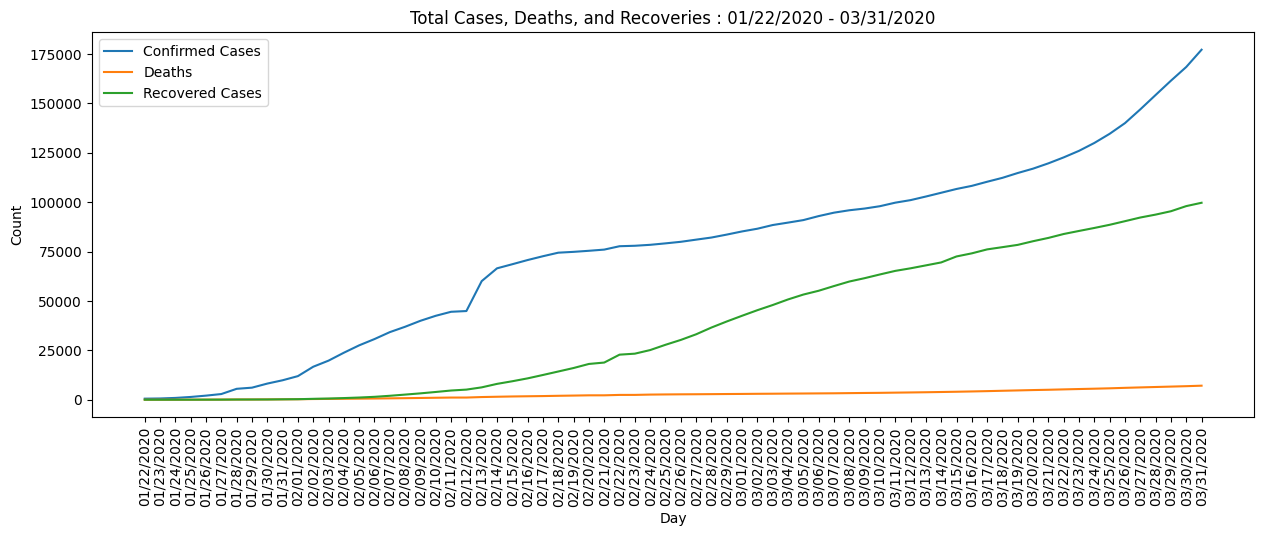

In [58]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize = [15,5])
plt.plot(a_df_perdate_tots['Confirmed'], label = "Confirmed Cases")
plt.plot(a_df_perdate_tots['Deaths'], label    = "Deaths")
plt.plot(a_df_perdate_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(asian_date_lst[0]);
fin_date   = str(asian_date_lst[len(asian_date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);

In [59]:
a_df["Closed Cases"] =  a_df["Deaths"] + a_df["Recovered"]
a_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered,Closed Cases
SNo,,,,,,,
1,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10655,03/31/2020,Tianjin,Mainland China,174.0,3.0,135.0,138.0
10656,03/31/2020,Tibet,Mainland China,1.0,0.0,1.0,1.0
10668,03/31/2020,Xinjiang,Mainland China,76.0,3.0,73.0,76.0


In [60]:
a_df["Open Cases"] = a_df["Confirmed"] - a_df["Closed Cases"] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
a_df

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered,Closed Cases,Open Cases
SNo,,,,,,,,
1,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0,0.0,1.0
2,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0,0.0,14.0
3,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0,0.0,6.0
4,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0,0.0,1.0
5,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10655,03/31/2020,Tianjin,Mainland China,174.0,3.0,135.0,138.0,36.0
10656,03/31/2020,Tibet,Mainland China,1.0,0.0,1.0,1.0,0.0
10668,03/31/2020,Xinjiang,Mainland China,76.0,3.0,73.0,76.0,0.0


##Growth Factor for asian cases

In [62]:
a_confGf = []
a_recGF = []
a_deathGF =[]
growth_len_lst = len(a_df_perdate_tots) - 1
a_conf = a_df_perdate_tots["Confirmed"]
a_rec = a_df_perdate_tots["Recovered"]
a_death = a_df_perdate_tots["Deaths"]

for i in range(growth_len_lst):
  confGf = a_conf[i+1]/a_conf[i]
  a_confGf.append(confGf)
  recGf = a_rec[i+1]/a_rec[i]
  a_recGF.append(recGf)
  deathGf = a_death[i+1]/a_death[i]
  a_deathGF.append(deathGf)


Text(0.5, 1.0, 'Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 for Asian Countries : 01/22/2020 - 03/31/2020')

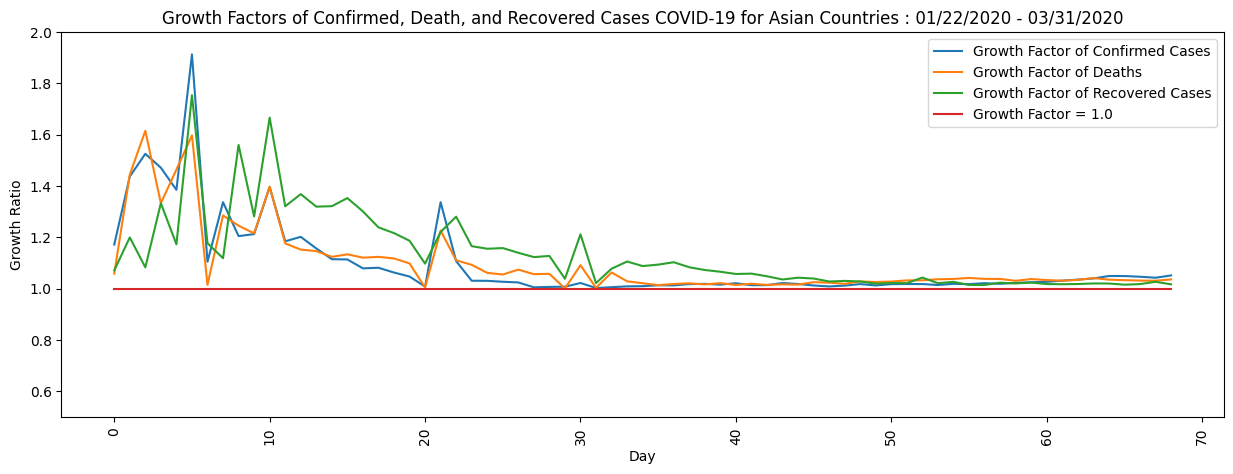

In [63]:
plt.figure(figsize = [15,5])
plt.plot(a_confGf, label = "Growth Factor of Confirmed Cases")
plt.plot(a_deathGF, label = "Growth Factor of Deaths")
plt.plot(a_recGF, label = "Growth Factor of Recovered Cases")
x = []
for i in range((growth_len_lst)):
    x.append(1)
plt.plot(x, label = "Growth Factor = 1.0")

#plt.grid()
plt.legend()
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90)
start_date = str(asian_date_lst[0])
fin_date   = str(asian_date_lst[len(asian_date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 for Asian Countries : " +start_date +" - " +fin_date)

##Applying Ridge Regression for the above data(Asian Countries Only)

In [64]:
days = []

for i in range(len(asian_date_lst)):
  days.append(i)

a_df_perdate_tots["Day"] = days
a_df_perdate_tots = a_df_perdate_tots[["Day","Confirmed","Deaths","Recovered"]]
a_df_perdate_tots

,Day,Confirmed,Deaths,Recovered
01/22/2020,0,552.0,17.0,28.0
01/23/2020,1,647.0,18.0,30.0
01/24/2020,2,930.0,26.0,36.0
01/25/2020,3,1419.0,42.0,39.0
01/26/2020,4,2088.0,56.0,52.0
...,...,...,...,...
03/27/2020,65,146931.0,6245.0,92211.0
03/28/2020,66,154209.0,6454.0,93683.0
03/29/2020,67,161441.0,6660.0,95390.0
03/30/2020,68,168380.0,6869.0,97984.0


In [65]:
X = np.array(a_df_perdate_tots["Day"]).reshape(-1,1)
y = np.array(a_df_perdate_tots["Confirmed"])

X 

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69]])

In [66]:
y

array([   552.,    647.,    930.,   1419.,   2088.,   2893.,   5535.,
         6118.,   8182.,   9860.,  11961.,  16705.,  19794.,  23798.,
        27536.,  30709.,  34215.,  36937.,  39958.,  42485.,  44511.,
        44888.,  60031.,  66501.,  68578.,  70699.,  72628.,  74416.,
        74838.,  75377.,  75977.,  77687.,  77916.,  78397.,  79130.,
        79923.,  81013.,  82080.,  83573.,  85171.,  86542.,  88407.,
        89636.,  90907.,  92932.,  94663.,  95878.,  96748.,  97934.,
        99720., 101012., 102830., 104739., 106655., 108223., 110310.,
       112291., 114733., 116942., 119627., 122639., 125957., 129938.,
       134573., 139972., 146931., 154209., 161441., 168380., 177112.])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.85,shuffle = False)

In [68]:
from sklearn.metrics import r2_score

##LinearRegression

In [69]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

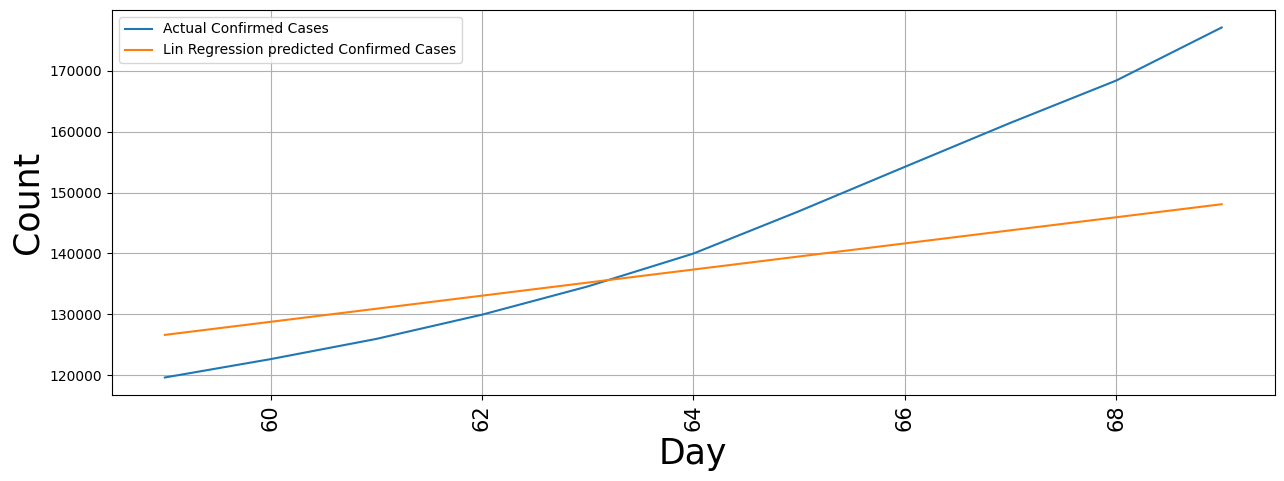

MAE: 10324.930282458627
MSE: 181730284.9709338
r2_score 0.4719329606087421


In [70]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, y_test))
print('MSE:', mean_squared_error  (test_lin_pred, y_test))
print ('r2_score', r2_score(y_test, test_lin_pred))

##Ridge Regression

In [71]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1e-07}


In [72]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

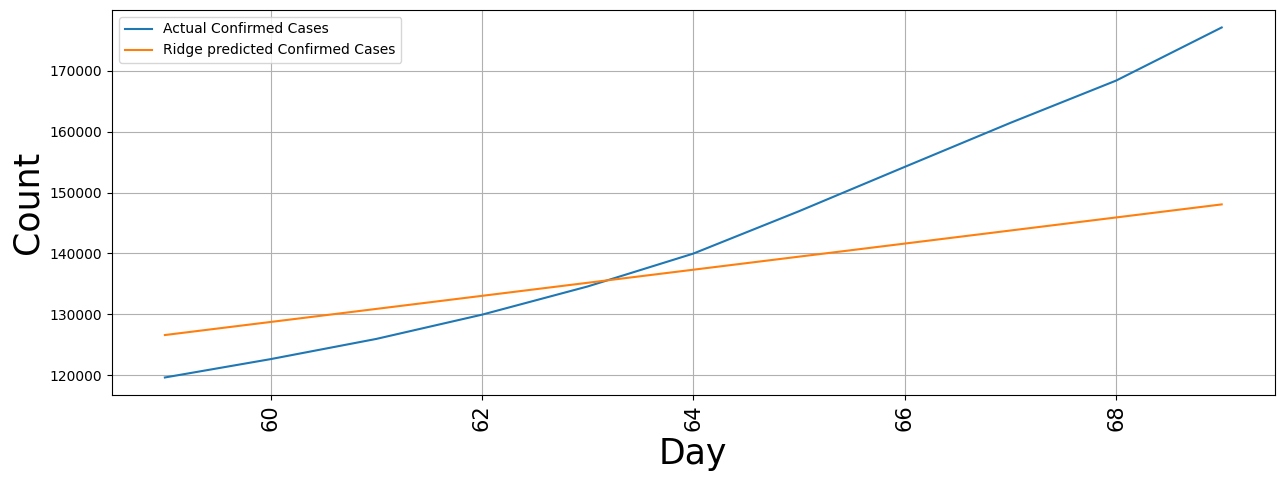

MAE: 10328.729666894087
MSE: 182125200.0418363
r2_score 0.4707854268757937


In [73]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, y_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, y_test))
print('r2_score', r2_score(y_test, y_test_ridge_pred))

##Polynomial

In [74]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [75]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)

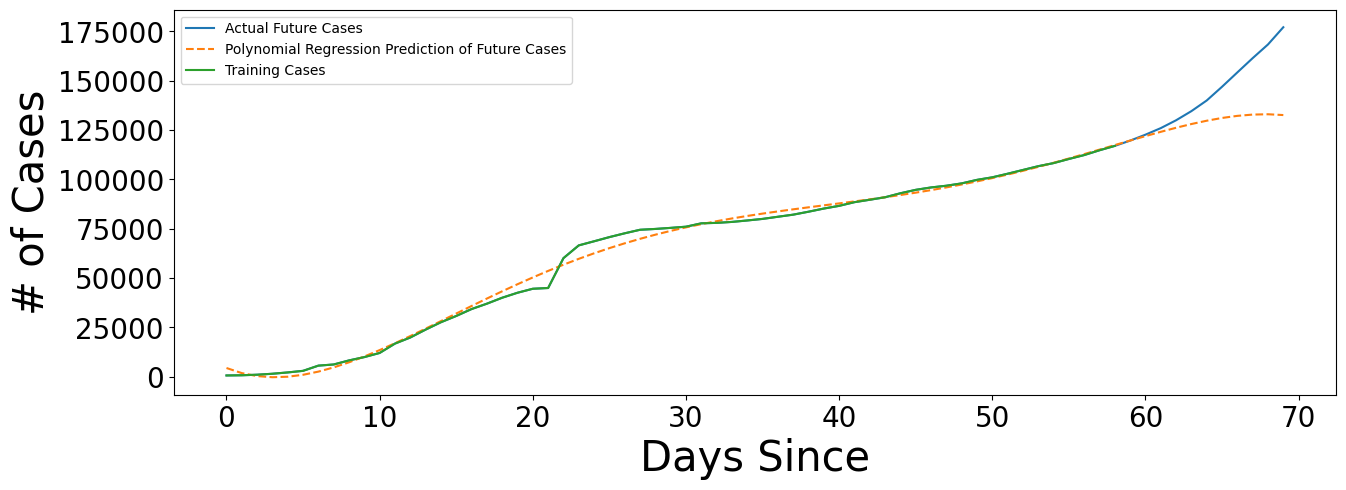

MAE: 15424.432671127586
MSE: 450761594.1259594


In [76]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()
print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

##Ridge Polynomial

In [77]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [78]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [79]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 1e-05, 'alpha_1': 1e-07}


In [80]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

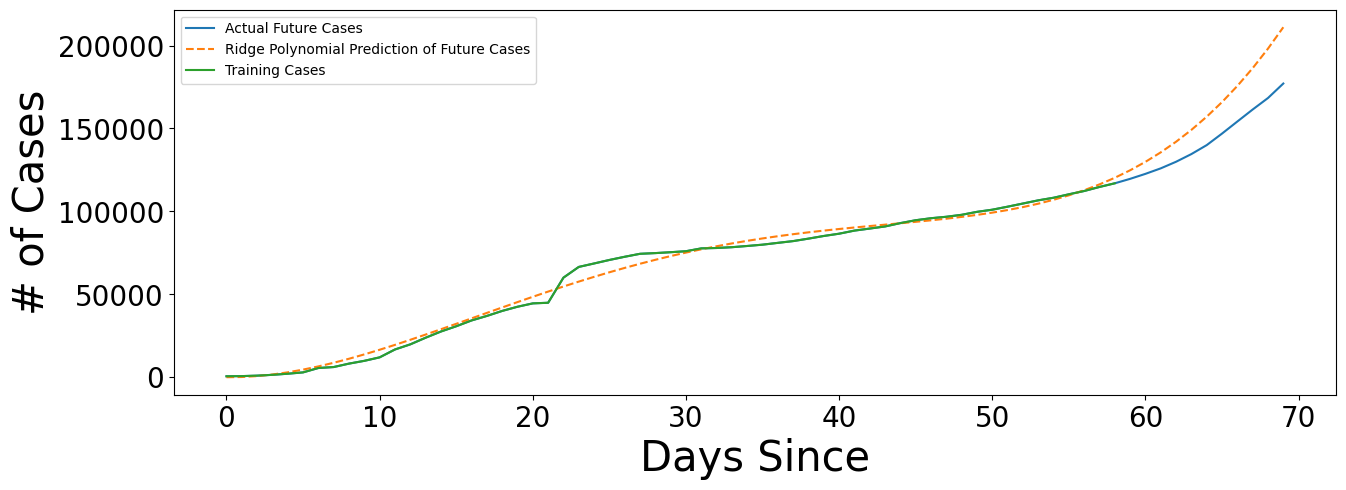

In [81]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [82]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))
print('\tr2_score', r2_score(y_test, y_test_ridge_pred))
print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))
print('\tr2_score', r2_score(test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 15424.432671127586
	MSE: 450761594.1259594
	r2_score 0.4707854268757937

Ridge Polynomial Regression 
	MAE: 17727.985590468987
	MSE: 391656064.7492258
	r2_score 0.47514767554786375


From Mean Absolute Error and Mean Squared Error values, Ridge Polynomial Regression Model seems to be the best model.
From the graph we also observe that the ridge polynomial predicts the future cases very accurately.